# IKEA Furniture: Comparing different Classfiication Methods

## Outline
- [Motivation](#Motivation)
- [Imports](#Imports)
- [Data Analysis](#Data-Analysis)
    - [Import IKEA Furniture Data-Set](#Import-IKEA-Furniture-Data-Set)
    - [Data Visualization](#Data-Visualization)
    - [Targets and Features](#Targets-and-Features)
    - [Correlation](#Correlation)
    - [Data Cleaning](#Data-Cleaning)
    - [Prepare Data for Prediction with a Tree-Based Algorithm](#Prepare-Data-for-Prediction-with-a-Tree-Based-Algorithm)
- [Decision Tree](#Decision-Tree)
    - [Test and Training Data-sets](#Test-and-Training-Data-Sets)
    - [First Version of the Decision Tree](#First-Version-of-the-Decision-Tree)
    - [First Improvements of the Decision Tree](#First-Improvements-of-the-Decision-Tree)
    - [Final Version of the Decision Tree](#Final-Version-of-the-Decision-Tree)
    - [Further Investigations of the Decision Tree](#Further-Investigations-of-the-Random-Forest-Model)
    - [Pruning](#Pruning)
- [Random Forest](#Random-Forest)
    - [Create a First Version of a Random Forest](#Create-a-First-Version-of-the-Random-Forest)
    - [First Improvements of the Random Forest](#First-Improvements-of-the-Random-Forest)
    - [Final Version of the Random Forest](#Final-Version-of-the-Random-Forest)
    - [Further Investigations of the Random Forest Model](#Further-Investigations-of-the-Random-Forest-Model)
- [Boosting](#Boosting)
    - [Create a First Version of Boosting](#Create-a-First-Version-of-Boosting)
    - [First Improvements of Boosting](#First-Improvements-of-Boosting)
    - [Final Version of Boosting](#Final-Version-of-Boosting)
    - [Further Investigations of Boosting Model](#Further-Investigations-of-Boosting-Model)
- [Conclusion and Remarks](#Conclusion-and-Remarks)


## Motivation

Within the scope of this project, the performance of different classification methods is investigated based on the IKEA Furniture data-set. The goal is to be able to predict the category of new furniture items. The performance of the investigated classification methods will be rated, depending on their prediction accuracy.

The data-set contains 2962 furniture items sold by IKEA and will be used to train and test the different methods. Common classification methods are the Logistic Regression, K-Nearest-Neighbour, Decision Tree or Support Vector Machines, to name a few. However, while many different classification methods exist, for this project, the focus will be on tree-based classification methods.

Tree-based classification methods can be used to predict a qualitative response for an observation based on a sequence of splitting rules. The splitting rules are summarized in a tree. An advantage of decision trees is that they are easy to understand and interpret. In addition, decision trees can handle both numerical and categorical data. This will be useful as the IKEA furniture data-set contains both numerical and categorical data. However, a disadvantage of decision trees is that they can create complex trees that do not generalise well. Furthermore, the trees do not have the same level of prediction accuracy as some other classification methods do.

Therefore, in order to construct more powerful prediction models, random forests and boosting are explored as well. Both random forest and boosting use trees as building blocks in their models.

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

#import graphviz

from matplotlib import pyplot as plt
from IPython.display import Image, display


%matplotlib inline
plt.style.use('ggplot') 
sns.set(style="white")

## Data Analysis

In a first step the given raw data is examined more closey. The main goal of the data analysis is to identify useful information and to better understand the data-set at hand. In order to prepare the raw-data for later use, steps of cleansing and transforming are included as well. 

### Import IKEA Furniture Data-Set

In [3]:
#read the data and delete the index of entry
IKEA_df = pd.read_csv('Data/IKEA_SA_Furniture_Web_Scrapings_sss.csv')
IKEA_df = IKEA_df.drop(IKEA_df.columns[0],axis =1)
IKEA_df.head(5)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [4]:
m = IKEA_df.shape[0]
n = IKEA_df.shape[1]
print('The data-set contains '+str(m)+' samples and '+str(n-1)+' features including the target-feature \'category\'')

The data-set contains 3694 samples and 12 features including the target-feature 'category'


### Data Visualization 

In the following the feature-name together with its data-type is listed (including the target-feature category). Note that the data-set contains both numerical as well as categorical data. 

In [5]:
# data type  
IKEA_df.dtypes

item_id                int64
name                  object
category              object
price                float64
old_price             object
sellable_online         bool
link                  object
other_colors          object
short_description     object
designer              object
depth                float64
height               float64
width                float64
dtype: object

Furthermore, some features are missing data:

In [6]:
IKEA_df.count() 

max_count = max(IKEA_df.count())

missing_data = []
for i in range(len(IKEA_df.count())):
        if IKEA_df.count()[i] < max_count:
            missing_data.append(i)
            
features = list(IKEA_df.count()[missing_data].index)
print('The data of the following ' +str(len(features))+ ' features is incomplete: ' +str(features))

The data of the following 3 features is incomplete: ['depth', 'height', 'width']


### Targets and Features
In the following an exploratory data analysis of the different features is performed. The main goal is to gather a better understanding of the data-set at hand. For that, each feature and its properties are examined individually.

#### item_id 

In [7]:
nun_id =  IKEA_df['item_id'].nunique()
print('Overall, ' + str(nun_id)+' unique item-id\'s exist.')
if nun_id <  m:
    print('However, not every item has a unique item-ID. Either some items share an item-ID or it might one and the same item.')

Overall, 2962 unique item-id's exist.
However, not every item has a unique item-ID. Either some items share an item-ID or it might one and the same item.


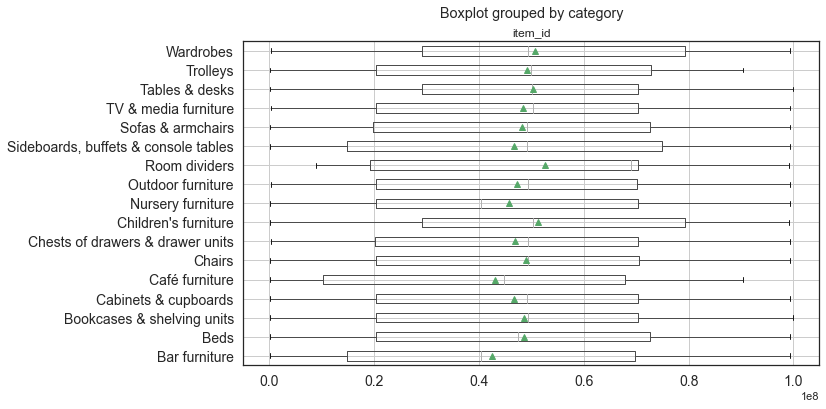

In [8]:
ax0 = IKEA_df.boxplot(column='item_id',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax0.set_xlabel('')
ax0.figure.savefig('Figures/Data_Analysis/item_id_boxplot.png',bbox_inches = 'tight')

The item_id is a number consisting of 5 to 8 digits. From the boxplot we can derive, that for most categories approximately 50% of the items  are taking a value between 2e7 and 7e7. Thus, item_id probably will not not give strong evidence of the category an item belongs to.  

#### name

In [9]:
nun =  IKEA_df['name'].nunique()
#print(IKEA_df['category'].unique())
print('There are ' + str(nun) + ' unique names in total.' )

There are 607 unique names in total.


In [10]:
name_df =  IKEA_df.groupby('category').agg({'name':'nunique', 'category':'size'})
name_df.columns=['n_uname','size']

In [11]:
name_df['uname [%]'] = name_df['n_uname']/ name_df['size']
name_df.sort_values(['uname [%]'], ascending=False)

,n_uname,size,uname [%]
category,,,
Trolleys,20,28,0.714286
"Sideboards, buffets & console tables",12,23,0.521739
Bar furniture,24,47,0.510638
Café furniture,12,26,0.461538
Chairs,222,481,0.461538
Tables & desks,245,612,0.400327
Room dividers,5,13,0.384615
Beds,76,208,0.365385
TV & media furniture,54,190,0.284211


In general, the feature 'name' can help determine the catogory. The feature 'name' might play a very important role for the prediction of category 'Sofas & armchairs' since close to 97% of the samples do not have an unique name. On the contrary, for category 'trolleys' the feature 'name' might not be as helpful as 70% of the samples have a unique name. 

#### category

In [12]:
nun =  IKEA_df['category'].nunique()
type_df = IKEA_df.groupby('category').size().reset_index(name='size').sort_values(['size'], ascending=False) 
print('There are ' + str(nun) + ' categories in total:\n')
list(type_df['category'])

There are 17 categories in total:



['Tables & desks',
 'Bookcases & shelving units',
 'Chairs',
 'Sofas & armchairs',
 'Cabinets & cupboards',
 'Wardrobes',
 'Outdoor furniture',
 'Beds',
 'TV & media furniture',
 'Chests of drawers & drawer units',
 "Children's furniture",
 'Nursery furniture',
 'Bar furniture',
 'Trolleys',
 'Café furniture',
 'Sideboards, buffets & console tables',
 'Room dividers']

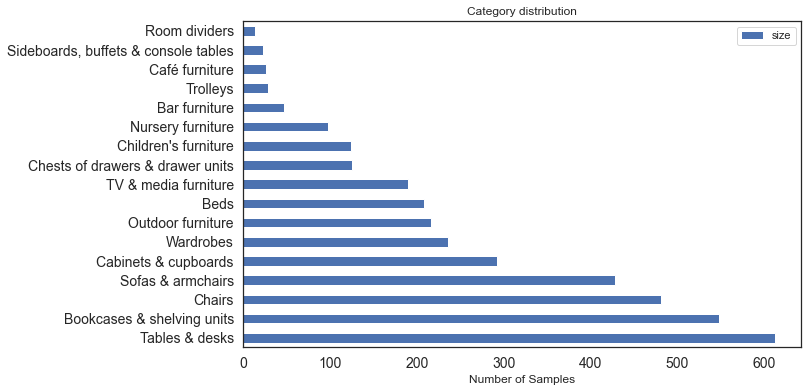

In [13]:
ax1 = type_df.set_index('category').plot.barh(rot=0, title='Category distribution',color = 'b',figsize=(10,6), fontsize=14)
ax1.set_xlabel("Number of Samples")
ax1.set_ylabel('')
ax1.figure.savefig('Figures/Data_Analysis/category_distribution.png',bbox_inches = 'tight')

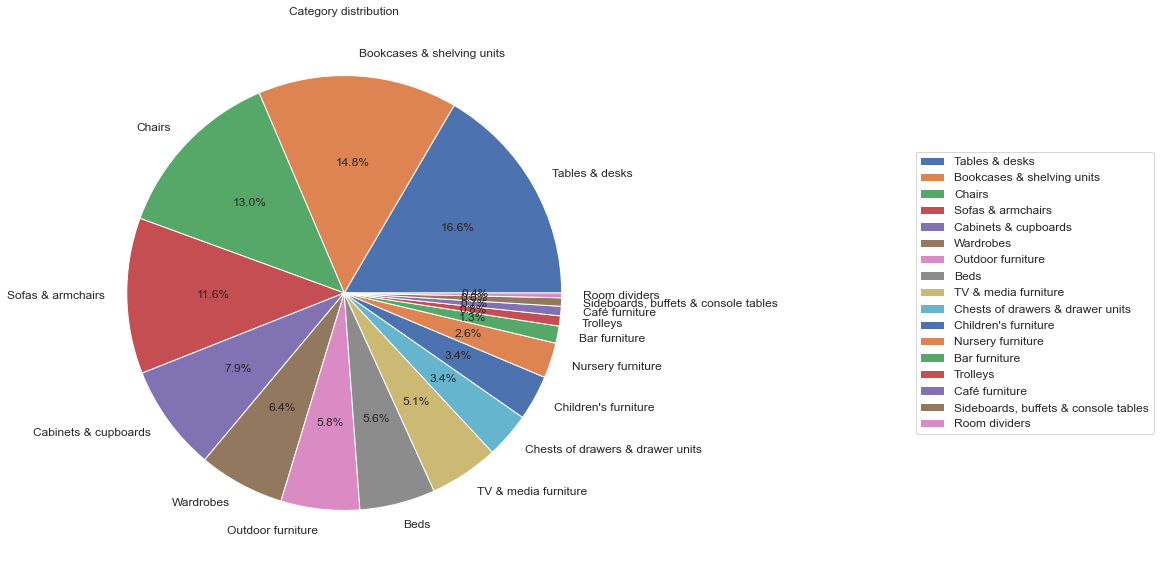

In [14]:
ax = type_df.set_index('category').plot.pie(title='Category distribution', y='size',figsize=(10,10), autopct='%1.1f%%',fontsize=12)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(2,0.5), loc="right", fontsize=12)
ax.figure.savefig('Figures/Data_Analysis/category_plotpie.png',bbox_inches = 'tight')

The category distribution is visulized above as a bar graph and a pie chart. From that, the follwoing observations can be made:\
Overall, almost 17% of the data-samples belong to the category 'Tables & desks', followed by the category 'Bookcases & sheiving units' with approx. 15% and the category 'Chairs' with 13%.\
On the contrary, the data-samples of the categories 'Room dividers', 'Sideboards', 'buffets & console tables', 'Cafe furniture' and 'Trolleys' accounts for less than 1%. Thus, it can be concluded, that the classification task itself is quite imbalanced. Hence, it might be necessary to replicate data-samples of the categories mentioned above, where the sample size is extremely small.

#### price

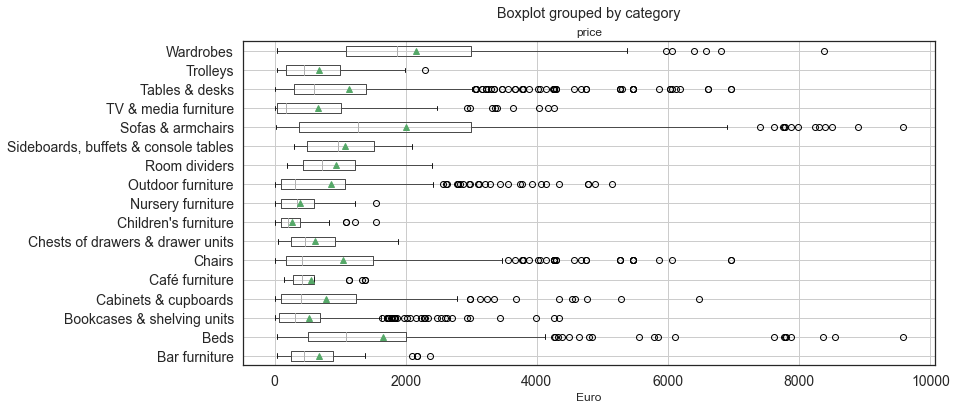

In [15]:
ax2 = IKEA_df.boxplot(column='price',by='category',vert=False, figsize=(12,6), fontsize =14,showmeans =True)
ax2.set_xlabel('Euro')
ax2.figure.savefig('Figures/Data_Analysis/price_boxplot.png',bbox_inches = 'tight')

As shown above in the boxplot of price, the furniture of the category 'Wardrobes' is most expensive, while the children's furnitures is the cheapest. The category 'Sofa & armchairs' has has the largest range in price from approximately 250€ up to 70.000€, while the ourliers can reach up to 90.000€. The category 'Cafe furniture' has the most "stable" price. The price area (Interquartile Range of price) of some categories do overlap. Still, in general it seems fair to say, that price can be a very useful feature in order determine the category of an item.

#### old-price

In [16]:
t = IKEA_df[IKEA_df['old_price'].str.contains('No old price')]['item_id'].count() /m
print( str( round(t,4)*100) + '% of feature old_price is \'No old price\'.' )

82.3% of feature old_price is 'No old price'.


It is  impossible to recover this data. Thus, the feature 'old_price' might not be helpful in order to determine the category and can therefore be ignored for training. 

#### sellable_online

In [17]:
t = IKEA_df[IKEA_df['sellable_online'] == True]['item_id'].count()/m
print( str( round(t,4)*100) + '% of feature \'sellable_online\' is \'True\'.' )

99.24% of feature 'sellable_online' is 'True'.


This means that the vast majority of items can be sold online. Because this feature is identical in most cases, most likely it cannot help determine the category of an item and therefore is deleted for training.

#### other_colors

In [18]:
t = IKEA_df[IKEA_df['other_colors'].str.contains('Yes')]['item_id'].count()/m
print( str( round(t,4)*100) + '% of feature other_colors is \'Yes\'.' )

40.93% of feature other_colors is 'Yes'.


#### designer

In [19]:
nun_designer =  IKEA_df['designer'].nunique()
#print(IKEA_df['designer'].unique())
print('There are ' + str(nun_designer) + ' different designers in total.' )

There are 381 different designers in total.


In [20]:
designer_df = IKEA_df.groupby('designer').size().reset_index(name='count').sort_values(['count'], ascending=False)
designer_df['count%'] = round(designer_df['count'] *100/m ,2) 
designer_df.head(5)

,designer,count,count%
192,IKEA of Sweden,828,22.41
138,Ehlén Johansson,161,4.36
163,Francis Cayouette,151,4.09
344,Ola Wihlborg,134,3.63
279,K Hagberg/M Hagberg,122,3.30


As shown in the table above, 22% of the items are not designed by a sepecific designer. The designer which designs most items is Ehlén Johanssons. However, Ehlén Johanssons only acount for about 4% in data-set. Ehlén Johanssons is closely follwoed by the designer Francis Cayoutte who accounts for approx. 4% of the designs. 

In [21]:
t = designer_df[designer_df['count']< 2].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+' designers design just 1 items in data-set.\n')

t = designer_df[designer_df['count']< 5].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+' designers design less than 5 items in data-set.\n')

t  = designer_df[designer_df['count']< 10].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+' designers design less than 10 items in data-set.\n')

139 of 381 designers design just 1 items in data-set.

278 of 381 designers design less than 5 items in data-set.

320 of 381 designers design less than 10 items in data-set.



In [22]:
IKEA_df['designer_len'] = IKEA_df['designer'].str.len() 
IKEA_df['designer_len'].describe()

count    3694.000000
mean       33.755820
std        86.016629
min         3.000000
25%        14.000000
50%        15.000000
75%        28.000000
max      1261.000000
Name: designer_len, dtype: float64

In [23]:
t = IKEA_df[IKEA_df['designer_len'] > 40].shape[0] 
print(str( round(t*100/m,2)) +'% samples have actually text of long description in feature designer' )

7.26% samples have actually text of long description in feature designer


We find that some entries in 'desinger' contain a more detailed description of the furniture itself instead of the designers name. We could replace those entries with 'designer unknowm', however,  this might be misleading later on as it could be understood by the algorithm as if the furniture was designed by one and the same person (called 'designer unknown') when instead the designer is not known.\
Moreover, the observation can be made that furniture of the same category might have the same description for the feature 'designer'. But considering those mistakes only acount for approximately 7% of the entire data-set, one can also just keep the original data.

#### Let's take a closer look at the TOP3 furniture-designers:
1. IKEA of Schweden (22.41%)
2. Ehlén Johansson (4.36%)
3. Francis Cayouette (4.09%)

*1. IKEA of Schweden (22.41%)*

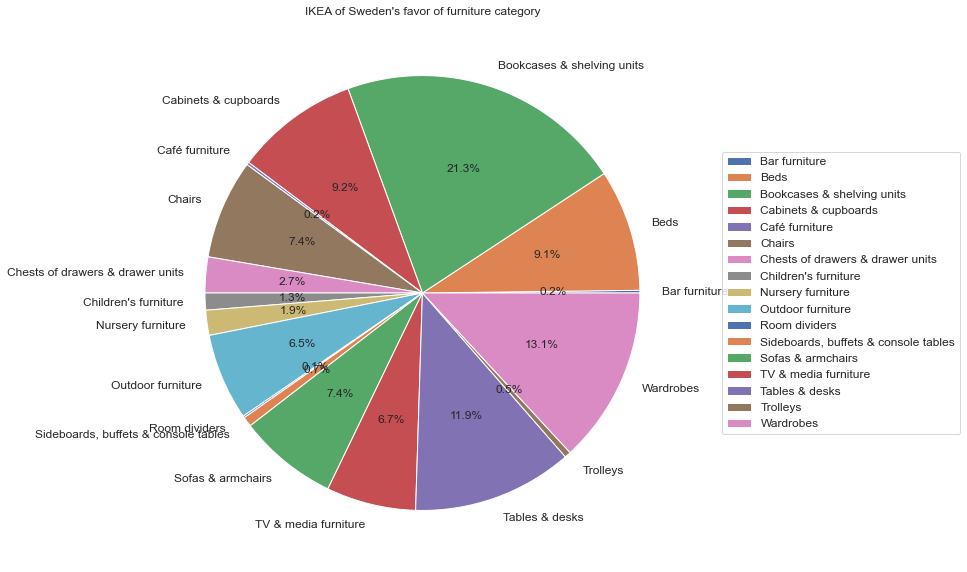

In [24]:
df1 = IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd1 = df1.set_index('category').plot.pie(title='IKEA of Sweden\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd1.set_ylabel('')
axd1.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)
axd1.figure.savefig('Figures/Data_Analysis/TOP1_designer.png',bbox_inches = 'tight')

'IKEA of Sweden' covers all 17  furniture catogeries. However, most designs are for category 'Bookcases & shelving units' accounting for a little over 20% of all designs.

*2. Ehlén Johansson (4.36%)*

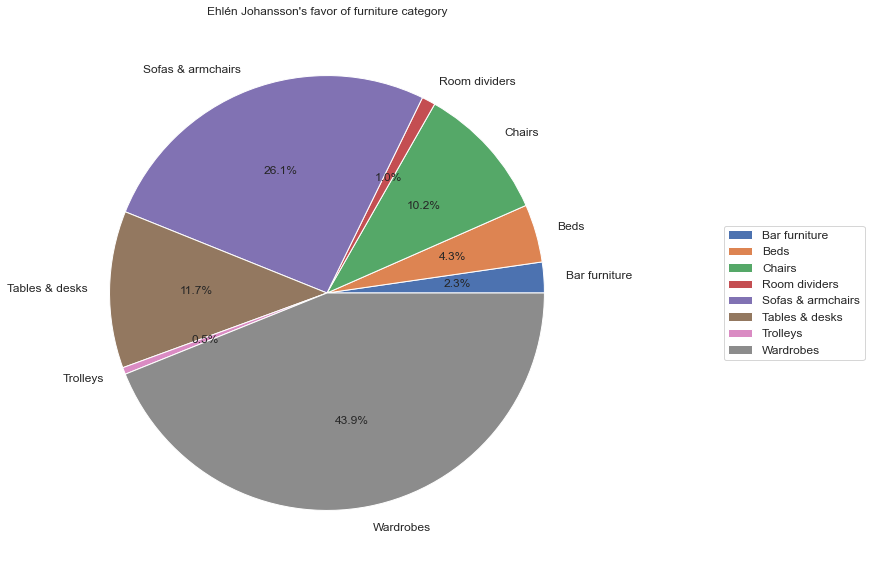

In [25]:
df2 = IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd2 = df2.set_index('category').plot.pie(title='Ehlén Johansson\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd2.set_ylabel('')
axd2.figure.savefig('Figures/Data_Analysis/TOP2_designer.png',bbox_inches = 'tight')
axd2.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)

Designer Ehlén Johansson seems to favor designing for the category 'Wardrobes' (over 40%), followed by category 'Sofas & armchairs' with approcimately 26%.

In [26]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes') & IKEA_df['designer'].str.contains('Ehlén Johansson')]['item_id'].count() 
print('About ' +str(round(t2/t1, 4)*100)+ '% of the items of category \'Wardrobes\' are designed by Ehlén Johansson (including the cases IKEA of Sweden/Ehlén Johansson and Ehlén Johansson/IKEA of Sweden).')

About 73.31% of the items of category 'Wardrobes' are designed by Ehlén Johansson (including the cases IKEA of Sweden/Ehlén Johansson and Ehlén Johansson/IKEA of Sweden).


*3. Francis Cayouette (4.09%)*

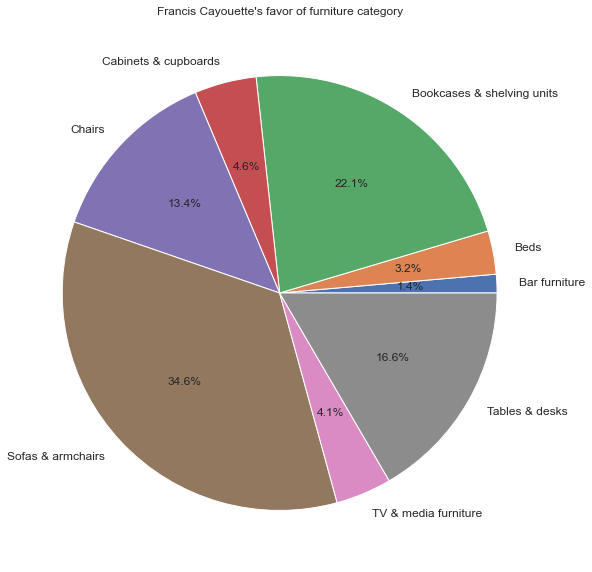

In [27]:
df3 = IKEA_df[IKEA_df['designer'].str.contains('Francis Cayouette')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd3 = df3.set_index('category').plot.pie(title='Francis Cayouette\'s favor of furniture category', y='count',figsize=(10,10),\
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd3.set_ylabel('')
#axd3.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)
axd3.figure.savefig('Figures/Data_Analysis/TOP3_designer.png',bbox_inches = 'tight')

Designer Francis Cayouette favors designing 'Sofas & armchairs' (approximately 35%), followed by the category 'Bookcases & sehlving units' with approximately 22% and category 'Tables % desks' accounting for almost 17%. 

In [28]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs') & IKEA_df['designer'].str.contains('Francis Cayouette')]['item_id'].count() 
print('Overall, around ' +str(round(t2/t1, 4)*100)+ '% of the items in category \'Sofas & armchairs\' are designed by Francis Cayouette.')

Overall, around 17.52% of the items in category 'Sofas & armchairs' are designed by Francis Cayouette.


#### depth, width,  height

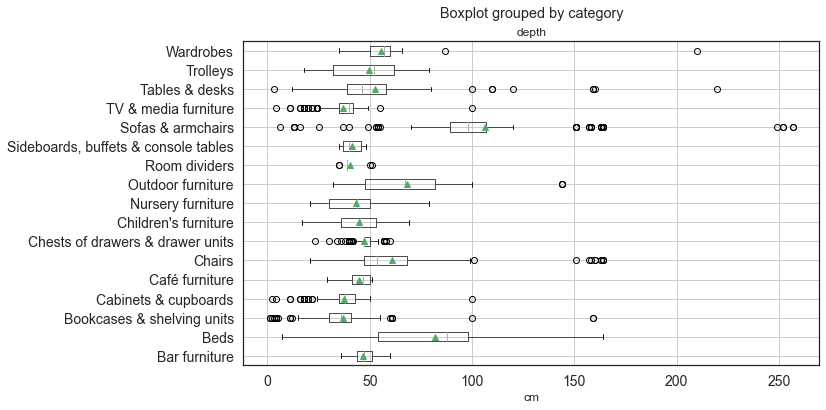

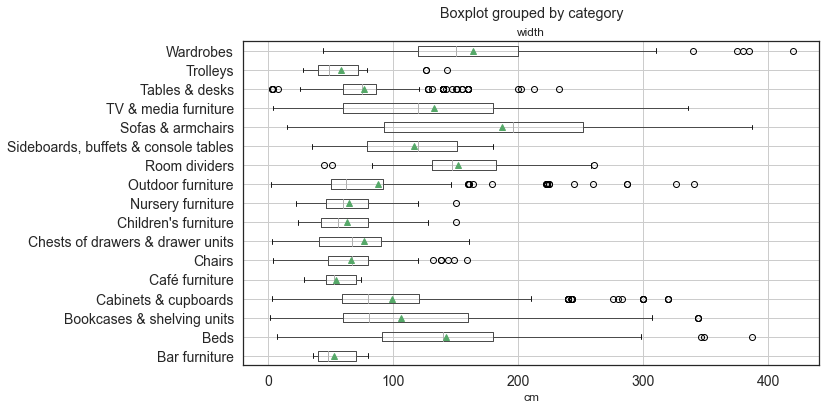

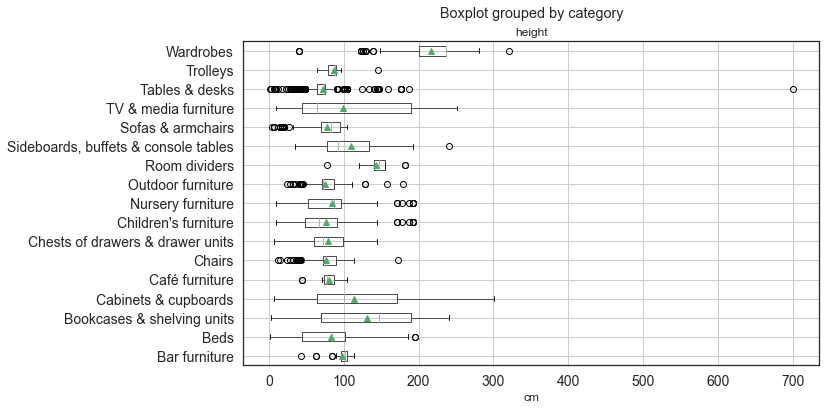

In [29]:
# depth boxplot
ax3 = IKEA_df.boxplot(column='depth',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax3.set_xlabel('cm')
ax3.figure.savefig('Figures/Data_Analysis/depth_boxplot.png',bbox_inches = 'tight')
# width boxplot
ax5 = IKEA_df.boxplot(column='width',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax5.set_xlabel('cm')
ax5.figure.savefig('Figures/Data_Analysis/width_boxplot.png',bbox_inches = 'tight')
# height boxplot
ax4 = IKEA_df.boxplot(column='height',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax4.set_xlabel('cm')
ax4.figure.savefig('Figures/Data_Analysis/height_boxplot.png',bbox_inches = 'tight')

Generally, the size-features 'depth', 'width', 'height' vary a lot throughout the different categories. This is the case in particular for the feature 'depth'. Therefore it is assumed, that the size-features might play an important role in predicting an items category. 

#### link, short_description

The features 'link' and 'short_desctiption' can be understood literally. Both features 'link' and 'short_description' are different for the individual items and uncorrelated to the category. Therefore, 'link' and 'short_description' will be ignored for the training.\
However, it should not go unnoted that 'short_description' sometains contains size-data,  which is not scrapped and assgined correctly. We can make use of this and recover some missing data (NaN) for 'depth', 'width' and 'height'. Unfortunately, in most cases this is technically very complicated. Furthermore, both features 'link' and 'short_description' contain key words, which would indicate  the items category straight away. It might be cheating to make use of that, while at the same time it would be extremely difficult to do so.

### Correlation

We would like to check the colinerity of numerical (including boolean) features. We can encode the nominal features as integer values by using 'factorize'.\ 
Although, this can be misleadings in some way, at this point we just want to have an idea of the correlation between the features. In case of training an algorithm that does not understand nominal features, we might use the one-hot encoding to avoid misunderstandings caused by numeric values. However, this can lead to a quite high computational cost. For example, for 370 different designers, one-hot encoding will create 9 more features, respectively, taking value 0/1 to present the feature designer.

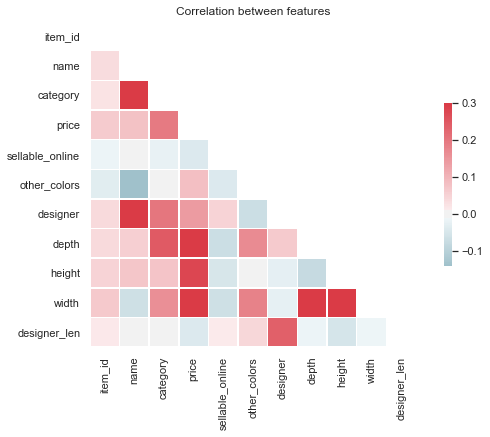

In [30]:
corr_df = IKEA_df.copy()

corr_df['category'] = pd.factorize(corr_df['category'])[0] + 1
corr_df['name'] = pd.factorize(corr_df['name'])[0] + 1
corr_df['sellable_online'] = pd.factorize(corr_df['sellable_online'])[0] + 1
corr_df['other_colors'] = pd.factorize(corr_df['other_colors'])[0] + 1
corr_df['designer'] = pd.factorize(corr_df['designer'])[0] + 1

# correlation / scatter matrix here
corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between features')
ax.figure.savefig('Figures/Data_Analysis/corr.png',bbox_inches = 'tight')

As shown by the analysis of the individual features above, 'depth' and 'price' play a relatively important role in determining the category of an item, whereas the features 'sellable_online' and 'other_colors' show a low correlation to the category. 
The feature 'price' also shows a relatively high correlation to the item-category as well as to the items depth, height and width. The features 'name' and 'designer' also show a relatively high correlation, indicating the colinearity of the features. This might result in bad predicitons in certain algorithms. Still, the correlation between features (including the target category) are not on a very high level as in all cases the correlation is below the value 0.3.

### Data Cleaning

The goal of the data cleaning is to detect and then correct corrupt or inaccurate data as well as prepare the data for later use.\
First of, the feature 'other_colors' is transformed from an object to a boolean:

In [31]:
IKEA_df['other_colors'] = IKEA_df['other_colors'].map({'Yes': True, 'No': False})

Rather as a coincidence we noticed that the designer 'Ehlén Johansson' is sometimes listed as 'IKEA of Sweden/Ehlén Johansson' and other times as 'Ehlén Johansson/IKEA of Sweden'. Because this seems to be one and the same person, the two were merged and saved as 'Ehlén Johansson/IKEA of Sweden'.

In [32]:
s1 = IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson')].shape[0]
s2 = IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson/IKEA of Sweden')].shape[0]
l = IKEA_df['designer'].shape[0]

print('Ehlén Johansson accounts for ' +str(s1)+ ' designs as \'IKEA of Sweden/Ehlén Johansson\' and for ' +str(s2)+ ' designs as \'Ehlén Johansson/IKEA of Sweden\'.')
print('Thus, in total ' +str(s1+s2)+ ' of the designs are from the desginer Ehlén Johansson. This means, in reality Ehlén Johansson accounts for ' +str(round((s1+s2)/l,4)*100)+ '% of the designs.')

Ehlén Johansson accounts for 79 designs as 'IKEA of Sweden/Ehlén Johansson' and for 86 designs as 'Ehlén Johansson/IKEA of Sweden'.
Thus, in total 165 of the designs are from the desginer Ehlén Johansson. This means, in reality Ehlén Johansson accounts for 4.47% of the designs.


In [33]:
IKEA_df['designer']= np.where(IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson'),  'Ehlén Johansson/IKEA of Sweden', IKEA_df.designer)

Next, the cells containing 'NaN' values are investigated more closely.

In [34]:
# determine where data is missing (cell is NaN)
shape_NaN = IKEA_df[IKEA_df.isnull().any(axis=1)].shape 
IKEA_df[IKEA_df.isnull().any(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,20
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,17
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
7,60155602,DALFRED,Bar furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/dalfred-bar-stool...,False,"Bar stool, 63-74 cm",Sarah Fager,50.0,NaN,50.0,11


It seems like data is only missing regarding the item-size (depth, height, width). Let's check if that is truely the case:

In [35]:
size = ['depth','height','width'] 
shape_size = IKEA_df[IKEA_df[size].isnull().any(axis=1)].shape 
s = IKEA_df[IKEA_df[IKEA_df.columns[~IKEA_df.columns.isin(size)]].isnull().any(axis=1)].shape
if s[0] == 0:
    print('The assumption made above is correct. All \'NaN\'-entries can be found in the rows \'depth\', \'height\', \'width\' describing the item-size.')

The assumption made above is correct. All 'NaN'-entries can be found in the rows 'depth', 'height', 'width' describing the item-size.


In [36]:
IKEA_df[IKEA_df[size].isnull().all(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,"SR 2,375",True,https://www.ikea.com/sa/en/p/ekedalen-ekedalen...,False,Bar table and 4 bar stools,Ehlén Johansson,NaN,NaN,NaN,15
28,29297227,STENSELE / NORRARYD,Bar furniture,1340.0,No old price,True,https://www.ikea.com/sa/en/p/stensele-norraryd...,False,Bar table and 2 bar stools,Nike Karlsson/Maja Ganszyniec,NaN,NaN,NaN,29
32,19297275,NORRÅKER / NORRÅKER,Bar furniture,1266.0,"SR 1,385",True,https://www.ikea.com/sa/en/p/norraker-norraker...,False,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,NaN,NaN,21


#### NaN in size data

By comparing the given data-set to the product size published on the website, the conclusion can be made, that there are several main reasons as to why some of the data regarding the item-size is missing.

First of, it seems that some data is not successfully scraped from the website. Because it is not recorded in the short description either it is impossible to recover the missing information regarding the item-size.
Second, some items represent a set of different furniture items. Therefore there is no product size in that sense.
Third, some items are variable in size. For example, an item can vary in its width, so instead of a a fix value, the width is a range.

Although some of the missing data could be scraped from the the short description as some size-data is recorded there. However, it is very difficult to extract the exact size for all items. The biggest problem is that it cannot be identified what numbers respond to the items depth, height and width. Furthermore, the data in the short description often is incomplete.

Last, there are some small items where the measurements ar taken in milimeters instead of centimeter. In addition, for some items a item-diameter is recorded in the short descritpion instead of the item-height.

In a first step, the size-data is separated from the short description. Then the size is split into the numeric value ('size_nounit') and its unit.

In [37]:
IKEA_df['size']= IKEA_df['short_description'].str.rsplit(',', n=1).str[1]
IKEA_df['short_description']= IKEA_df['short_description'].str.rsplit(',', n=1).str[0]

IKEA_df['unit'] = IKEA_df['size'].str.replace('\d+|-|x', ' ')
IKEA_df['size_nounit'] = IKEA_df['size'].str.replace('cm|mm', '')

The following will show, that indeed, 'height' is not given for the small items. In this case it is convenient to extract the diameter from the short description and replacing the NaN in height with the diamater. Additionally, the information given on the website indicates that the unit size-data for small items is in fact 'mm'. In the following, the unit for the small items will be corrected.  

In [38]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df[size].isnull().any(axis=1)].shape

(132, 17)

In [39]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df['height'].isnull()].shape

(132, 17)

In [40]:
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm') , IKEA_df.size_nounit, IKEA_df.height)
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.height.astype(float)/10, IKEA_df.height)
IKEA_df['height'] = IKEA_df['height'].astype(float)

In [41]:
IKEA_df['depth'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.depth.astype(float)/10, IKEA_df.depth)
IKEA_df['width'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.width.astype(float)/10, IKEA_df.width)

For simplicity, the 'NaN'-cells in size-data are filled with either the mean or the median depending on the category and wether there are many outliers in size data (refer to the boxplot from earlier).\
In case there are many outliers resulting in the mean beeing significantly higher than the median, the NaN-cells are filled with the median.

In [42]:
dm =IKEA_df.groupby('category')['depth'].median().reset_index(name = 'depth_median')
dd = IKEA_df.groupby('category')['depth'].mean().reset_index(name = 'depth_mean')
hm = IKEA_df.groupby('category')['height'].mean().reset_index(name = 'height_mean')
hd = IKEA_df.groupby('category')['height'].median().reset_index(name = 'height_median')
wm= IKEA_df.groupby('category')['width'].median().reset_index(name = 'width_median')
wd =IKEA_df.groupby('category')['width'].mean().reset_index(name = 'width_mean')

In [43]:
IKEA_df = IKEA_df.join(dm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(dd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wd.set_index('category'), on='category')

In [44]:
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Tables & desks')),  \
                              IKEA_df.depth_median, IKEA_df.depth )
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Sofas & armchairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )        
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Chairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )

In [45]:
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('TV & median furniture')),  \
                              IKEA_df.height_median, IKEA_df.height )
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('Sideboards, buffets,console tables')),  \
                              IKEA_df.height_median, IKEA_df.height )

In [46]:
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Wardrobes')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Outdoor furniture')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Carbinets & cupboards')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Bookcases & shelving units')),  \
                            IKEA_df.width_median, IKEA_df.width)

In [47]:
IKEA_df['depth'] = np.where(IKEA_df['depth'].isnull(), IKEA_df.depth_mean, IKEA_df.depth)
IKEA_df['height'] = np.where(IKEA_df['height'].isnull(), IKEA_df.height_mean, IKEA_df.height)
IKEA_df['width'] = np.where(IKEA_df['width'].isnull(), IKEA_df.width_mean, IKEA_df.width)

### Prepare Data for Prediction with a Tree-Based Algorithm

Tree-based algorithms do not work with calculating distances. Therefore, it is sufficient to factorize the categorical features.

In [48]:
learn = ['item_id','name','category','price','sellable_online','other_colors','designer','depth','height','width' ]
learn_df = IKEA_df [learn]

In [49]:
#this cell gives warning about setting copy. This warning can be ignored in this project
learn_df['category_num'] = pd.factorize(learn_df['category'])[0] + 1
learn_df['name'] = pd.factorize(learn_df['name'])[0] + 1
learn_df['designer'] = pd.factorize(learn_df['designer'])[0] + 1

C:\Users\Marimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Marimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Marimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [50]:
if learn_df[learn_df.isna().any(axis =1)]['item_id'].count() ==0:
    print('The dataframe does not contain any \'NaN\'-entries.')

The dataframe does not contain any 'NaN'-entries.


In [51]:
label = IKEA_df['category'].unique()
label = label.tolist()
print('labels:', label)

labels: ['Bar furniture', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Café furniture', 'Chairs', 'Chests of drawers & drawer units', "Children's furniture", 'Nursery furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets & console tables', 'Sofas & armchairs', 'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']


In [52]:
t = learn_df.drop(columns = ['category','category_num']).shape[1]
print('There are '+str(t)+' features.')

There are 9 features.


After modifying and cleaning the data frame, it is suitable for tre-based algorithms.

## Decision Tree

We are exploring the method of Classification Trees in order to classify the IKEA Furniture Data-Set. One advantage of Trees is, that they can easily handle qualitative variables without the use of dummy variables. Therefor, this method seems to be particularly fitting for the classification problem at hand.

In [53]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

### Test and Training Data-Sets

In order to create a first version of the decision tree the data-set is split into a training  and a test data-set. In the following the function 'train_test_split' from sklearn will be used to split the data-set, whereas 2/3 of the data will be used for training and 1/3 for testing.\
In order to produce reproducible outputs across multiple function calls, the parameter 'random_state' is set to an integer value. At default the random_state would be set to 'None'.

In [54]:
train_size = 0.67
## default=None #Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls
random_state = 1 

def test_train_dataset(df, predictors, size, state):
    
    X = df[predictors].values
    y = df.category.values.reshape(-1,1) # get the response
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size,  random_state=state) 
    
    return X_train, X_test, y_train, y_test

### First Version of the Decision Tree

For a first version of the decision tree, the minimum number of samples required to be at a leaf node will be set to 20. Later, the influence of this parameter on the model accuracy will be examined more closely.

In [55]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

The predictors for this first model will be the follwing features: 'item_id', 'name', 'price', 'sellable_online', 'other_colors', 'designer', 'depth', 'height', 'width'. 
In the nex steps, the data-set (learn_df) is split into a training and test data-set. Then the model can be trained and first predictions can be made.

In [56]:
predictors = learn_df.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

In [57]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df, predictors, train_size, random_state)

In [58]:
tree_est = clf.fit(X_train, y_train) 
y_pred = tree_est.predict(X_test)

#### Visualization

In [59]:
import graphviz
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = tree.export_graphviz(tree_est, out_file='Figures/Decision_Trees/seat_tree_1.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True)



with open('Figures/Decision_Trees/seat_tree_1.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
# I.view()

ModuleNotFoundError: No module named 'graphviz'

So we see that the initial splitting occurs with Depth and Height predictors. 

#### Evaluation of the First Version

In a first step the importance of the individual features as predictors is investigated by comparing the average gini indices of the different features. 

In [60]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
depth,0.416935
height,0.292824
name,0.195664
price,0.040315
width,0.021651
designer,0.020436
item_id,0.007963
other_colors,0.004212
sellable_online,0.000000


As the table shows, the most important features according to the Gini Index are 'depth' (approx. 40%), 'height' (approx. 30%) and 'name' (approx. 20%). The other features such as 'price', 'width' or 'designer' each account for less than 5%. As was suspected earlier when analyzing the raw-data, the feature 'sellable_online' does not have any importance as almost all products are sellable-online. It is similar goes for the feature 'other_colors' as most items are available in different colors. On the contrary, 'item_id' is unique for the vast majority of items, therefore the feature 'item_id' is not a good indicator for the item category as well, resulting in a low importance of the feature.

In a next step the confusion matrix is created and the training and test accuracy are computed.

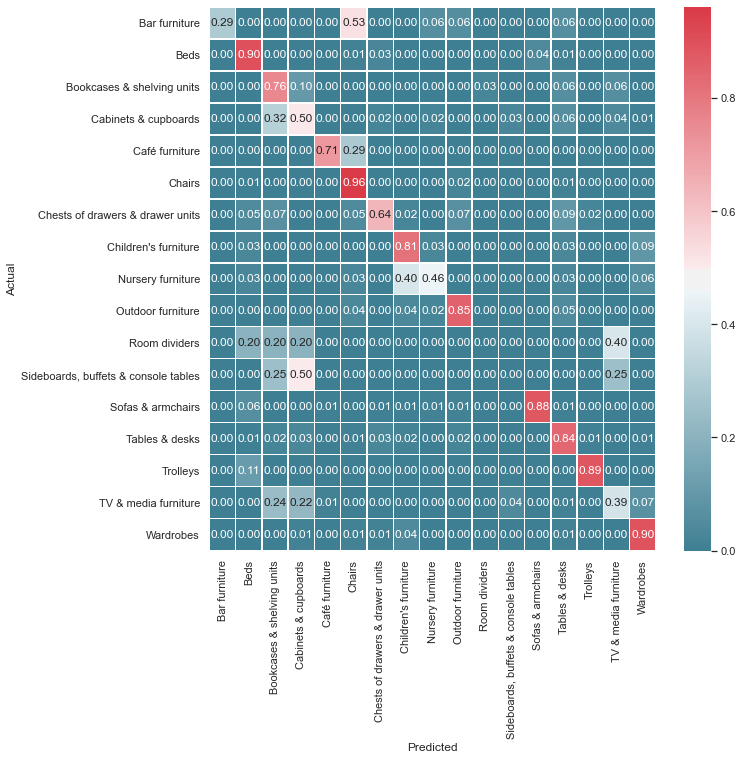

In [61]:
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label) 

# number of samples that actually belong to each category
cm_sum = cm.sum(axis = 1)
cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

# plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_1.png', bbox_inches = 'tight')

The confusion matrix shows that the prediction works well for must categories. However, the decision tree performs poor for items of categories 'Room dividers' and 'Sideboards, buffets & console tables'. The prediction could also be improved for items of categories 'Bar furniture', 'Nursery furniturs' and 'TV & media furniture'. 

In [62]:
# determine training accuracy 
y_pred_train = tree_est.predict(X_train)
accuracy_train_1 = accuracy_score(y_train, y_pred_train)
print("Training accuracy:", round(accuracy_train_1,4))
# determine test accuracy
accuracy_test_1 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_1,4))

Training accuracy: 0.8601
Test accuracy: 0.7697


### First Improvements of the Decision Tree

As a first attempt to improve the decision tree, all features with an importance of less than 2% are excluded from the set of predictors. This is the case for the following features: 'item_id', 'other_colors' and 'sellable_online'. For that, adjust the dataframe which is used to create the training and test data-set and then fit the decision tree to the new data-set ('learn_df_improvement').

In [63]:
learn = ['item_id','name','price','designer','depth','height','width','category','category_num' ]
learn_df_improvement = learn_df[learn]

In [64]:
predictors

['item_id',
 'name',
 'price',
 'sellable_online',
 'other_colors',
 'designer',
 'depth',
 'height',
 'width']

In [65]:
predictors.remove('item_id')
predictors.remove('other_colors')
predictors.remove('sellable_online')

In [66]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_improvement, predictors, train_size, random_state)

In [67]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)
tree_est = clf.fit(X_train, y_train)
y_pred = tree_est.predict(X_test)

#### Visualization of the Decision Tree

In [68]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
# dot_data = tree.export_graphviz(tree_est, out_file='Figures/Decision_Trees/seat_tree_2.dot',feature_names=predictors, 
#                filled=True, rounded=True, special_characters=True) #class_names=['True', 'False']

# with open('Figures/Decision_Trees/seat_tree_2.dot') as f:
#    dot_graph = f.read()  

# create the source object
# I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
# Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
# I.view()

#### Evaluation of the First Improvement

Again, in a first step the Gini Index of the individual features which were used as predictors are compared. Then the confusion matrix is created and the training and test accuracy is computed. 

In [69]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
depth,0.415617
height,0.284873
name,0.213865
price,0.033931
width,0.027783
designer,0.023931


The results are very similar to the results of the first decision tree. Again, 'depth' is the most important feature with slightly over 40%. 'depth' is followed by 'height' and 'name' which account to almost 30% and slightly over 20%, respectively. The features with the lowest importance are 'price', 'designer' and 'width'. As previously, again each account for less then 5%. 

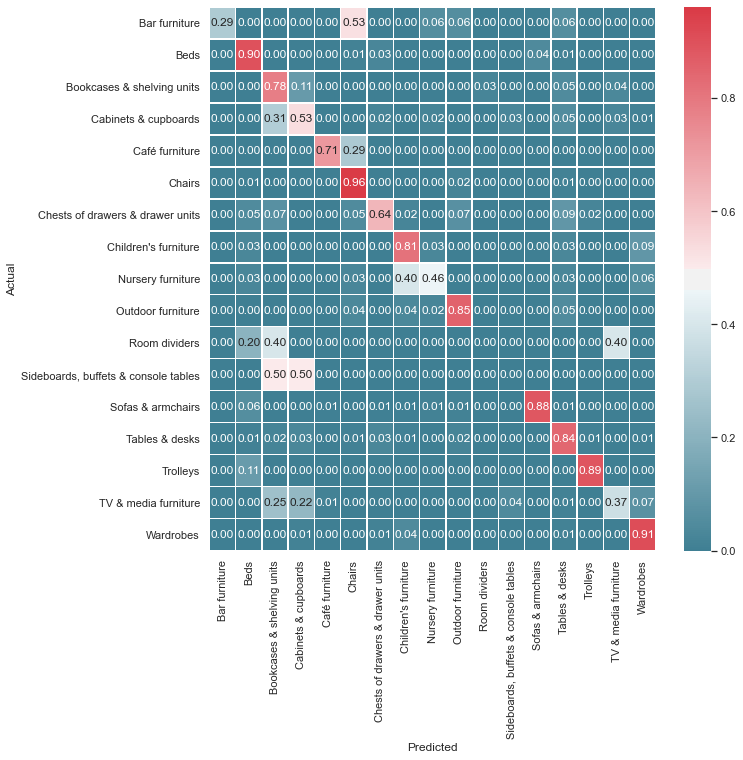

In [70]:
# Lets also get the training error rate of the tree model
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label) 
#print(cmatrix)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_2.png', bbox_inches = 'tight')

The confusion matrix is very similar to the one of the first decision tree. Although, the prediction was improved ever so slightly for some categories such as 'Cabinets and Cupboards' (+ 0.04), the decision tree still performs poorly when predicting the category of items that belong to the categories 'Room dividers' and 'Sideboards, buffets & console tables'. Also, the prediction accuracy of the following categories is not very satisfying as well: 'Bar furniture', 'Nursery furniture' and 'TV % media furniture'.

In [71]:
# determine training accuracy 
y_pred_train = tree_est.predict(X_train)
accuracy_train_2 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_2-accuracy_train_1)/accuracy_train_2)*100,2)
print("Training accuracy:", round(accuracy_train_2,4))
if improvement_train >0.0:
    print("The training accuracy improved by " +str(improvement_train)+ "%.\n")
elif improvement_train <0.0:
    print("The training accuracy deteriorated by " +str(improvement_train)+ "%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")

# determine test accuracy
accuracy_test_2 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_2,4))
improvement_test = round(((accuracy_test_2-accuracy_test_1)/accuracy_test_2)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ "%.\n")
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ "%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.8553
The training accuracy deteriorated by -0.57%.

Test accuracy: 0.7762
The test accuracy improved by 0.84%.



#### Replicate the Samples for a Small Sample Size

In the data analysis we found, that the sample size varies depending on the category. We noticed that especially for those categories, that have fewer samples, the decision tree performs poorly. In an effort to balance the sample size of categories with very few samples, some samples were replicated. 
Recall the sample size of the individual categories:

In [72]:
size_df = learn_df_improvement.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


Remeber the confusion matrix after the first improvments: The prediction accuracy of the categories 'Sideboards, buffets & console tables', 'Room dividers' was significantly lower than for the other categories. Both categories have a very low number of samples compared to other categories such as 'Beds' where the prediction accuracy was 90%.

In [73]:
# careful here the order of the labels somehow changed compared to the list 'label' above. The order of TV & median furniture
# tables& dsks and trollyes somehow echanged as can be seen below . Thus, we cannot use the list label to display the correct order of 
# column names in this section.
label1 =size_df['category'].tolist()

if label!=label1:
    print('Label does not equal label1. In the following, therefore label1 will be used.')

Label does not equal label1. In the following, therefore label1 will be used.


In [74]:
learn_df_final = learn_df_improvement.copy(deep=True)

In [75]:
label_size = size_df['size'].tolist()
for k in range(len(label1)):
    temp_df = learn_df_improvement[learn_df_improvement['category'].str.contains(label1[k])] 
    tt = round(max(label_size)/label_size[k]) -1
    if tt > 0:
        temp_df_improvement = pd.concat([temp_df]*tt, ignore_index=True)
        learn_df_final = pd.concat([learn_df_final, temp_df_improvement] , ignore_index=True)
     

In [76]:
#new relative balanced data set with duplicated samples
size_df_final = learn_df_final.groupby('category').size().reset_index(name='size')
size_df_final

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


By replicating samples for some categories, the number of samples of the data-set now is relatively balanced. However, note that by replicating samples now the categories which were lacking samples before now contain many duplicate samples.

### Final Version of the Decision Tree

Create a decision tree using the modified data-set 'learn_final'.

In [77]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

In [78]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)
tree_est = clf.fit(X_train, y_train)
y_pred = tree_est.predict(X_test)

#### Visualization of the Decision Tree

In [79]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
#dot_data = tree.export_graphviz(tree_est, out_file='Figures/Decision_Trees/seat_tree_3.dot',feature_names=predictors, 
#                filled=True, rounded=True, special_characters=True) #class_names=['True', 'False']



#with open('Figures/Decision_Trees/seat_tree_3.dot') as f:
#    dot_graph = f.read()  

# create the source object
#I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
#Image(I.render())
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
#I.view()

#### Evaluation of the Final Decision Tree

Again, in a first step the Gini Index of the individual features which were used as predictors are compared. Then the confusion matrix is created and the training and test accuracy is computed. 

In [80]:
feature_importances = tree_est.feature_importances_
feature_importances = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
feature_importances

,Importance
name,0.384259
depth,0.275370
height,0.168385
width,0.071362
price,0.064539
designer,0.036086


Now, the most important feature is 'name' with almost 40% followed by the size-features 'depth', and 'height'. The features 'width', 'price' and 'designer' are not as important for the prediction of the feature 'category'. Each of them account for (significantly) less than 10%. 
The importance of the different features used to predict the category of an item are also displayed in tha bar-graph below in increasing order. 

Text(0.5, 1.0, 'Feature importance')

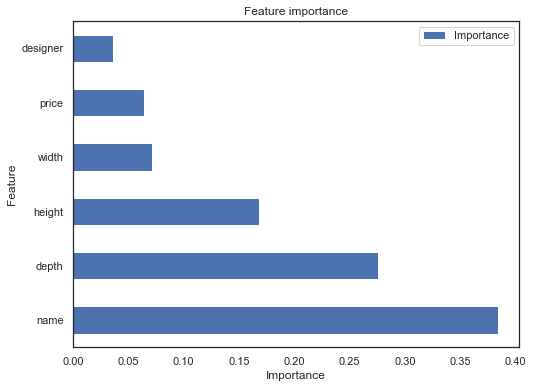

In [81]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_importances.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

Again the confusion matrix is created and the training and test accuracy is determined.

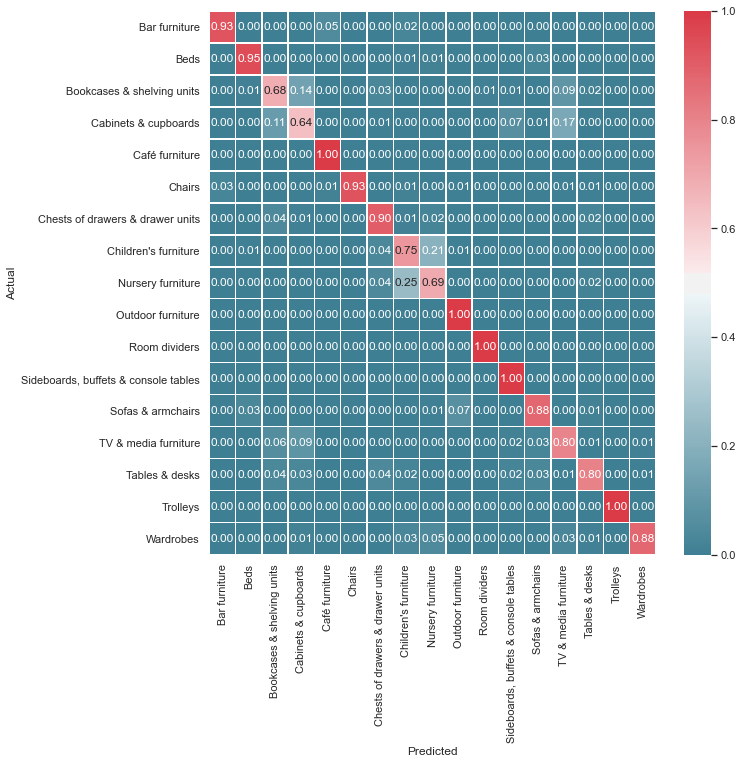

In [82]:
# get the confusion_matrix for the test data-set
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label1) 
#print(cmatrix)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label1),len(label1)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label1, columns=label1)

# plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Decision_Trees/DT_CM_3.png', bbox_inches = 'tight')

It seems that by replicating samples for the categories with very few samples, the prediction was improved significantly. Now, the prediction accuracy is at least 64% for all categories. Still, the prediction for the categories which only had few samples is not as accurate as it is for categories which had a lot of samples such as 'Beds'. However, not all categories perform well just because the data-set included a lot of different samples. An example for that would be category 'Bookcases & shelving units'.\ 
The prediction works best for the following categories and even reaches an accuracy of  100%: 'Café furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets &console tables', 'Trolleys'.

In [83]:
# calculate the training accuracy 
y_pred_train = tree_est.predict(X_train)
accuracy_train_3 = round(accuracy_score(y_train, y_pred_train),4)
improvement_train = round(((accuracy_train_3-accuracy_train_2)/accuracy_train_3)*100,2)
print("Model training accuracy:", accuracy_train_3)
if improvement_train >0.0:
    print("The training accuracy improved by" +str(improvement_train)+ '%.\n')
elif improvement_train <0.0:
    print("The training accuracy deteriorated by" +str(improvement_train)+ '%.\n')
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")
    
# calculate the test accuracy
accuracy_test_3 = round(accuracy_score(y_test, y_pred),4)
print("Model test accuracy:", accuracy_test_3)
improvement_test = round(((accuracy_test_3-accuracy_test_2)/accuracy_test_3)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ '%.\n')
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ '%.\n')
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Model training accuracy: 0.9101
The training accuracy improved by6.02%.

Model test accuracy: 0.876
The test accuracy improved by 11.39%.



### Further Investigations of the Decision Tree

Now we examine how the decision tree performs for different parameter settings. Using 'trial and error' we iteratively investigate the impact of the following parameters: ``max_depth``, ``min_samples_split`` and ``min_samples_leaf``. 

The parameter ``'min_samples_split'`` defines the minimum number of samples needed to split the tree. This value was previously set to 20. Now we wil investigate, how this value influences the overall accuracy of the decision tree.\
The parameter ``min_samples_leaf`` defines the minimal number of samples to be at a leaf node. Thus, split points will only be considered if at least min_samples_leaf training samples are left in each of the branches.

In [84]:
min_samples_split = [2,4,6,8,10,12,14,16,20,24]
min_samples_leaf = [1,3,5,7]

X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

In [85]:
result = []

for min_leaf in min_samples_leaf:    
    for min_split in min_samples_split:
        
        start_time = time.time()

        clf =  tree.DecisionTreeClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)

        end_time = time.time() - start_time

        accuracy_test = accuracy_score(y_test, y_pred)
        y_pred_train = tree_est.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_pred_train)

        feature_importances = tree_est.feature_importances_
        feature_importances = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                                             ascending=False)

        result.append(
            {
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf ,
                'time': end_time,
                'training accuracy': accuracy_train,
                'test accuracy': accuracy_test,
                'importance': feature_importances
                }
            )

        print('===========Process for Param estimator min_samples_split %d, min_samples_leaf %d ===========' % (min_split, min_leaf))
        print('time consumption: '+ str(end_time))
        #print('Overall train acuracy: ' +str(accuracy_train))
        print('Overall test acuracy: ' +str(accuracy_test))

===========Process for Param estimator min_samples_split 2, min_samples_leaf 1 ===========
time consumption: 0.019979476928710938
Overall test acuracy: 0.890653085680048
===========Process for Param estimator min_samples_split 4, min_samples_leaf 1 ===========
time consumption: 0.019914627075195312
Overall test acuracy: 0.8885560215698023
===========Process for Param estimator min_samples_split 6, min_samples_leaf 1 ===========
time consumption: 0.018950223922729492
Overall test acuracy: 0.8885560215698023
===========Process for Param estimator min_samples_split 8, min_samples_leaf 1 ===========
time consumption: 0.019026994705200195
Overall test acuracy: 0.8858597962852007
===========Process for Param estimator min_samples_split 10, min_samples_leaf 1 ===========
time consumption: 0.018075227737426758
Overall test acuracy: 0.8873576992210904
===========Process for Param estimator min_samples_split 12, min_samples_leaf 1 ===========
time consumption: 0.01892232894897461
Overall test ac

As the time consumption is very low for the Decision Tree Classifier, the computation time will not be taken into account when determining the best parameter combination. 

In [86]:
res = pd.DataFrame(result)

accuracy_test =  res['test accuracy'].max()
best_min_split = res.loc[res['test accuracy'].idxmax(), 'min_samples_split']
best_min_leaf = res.loc[res['test accuracy'].idxmax(), 'min_samples_leaf']
accuracy_train = res.loc[res['test accuracy'].idxmax(), 'training accuracy']
time = res.loc[res['test accuracy'].idxmax(), 'time']
    
print("The best results are achieved with the following settings:\n\nmin_samples_split: %d\nmin_samples_leaf: %d\n\ntest accuracy: %4.3f\ntime consumption: %4.3f" % (best_min_split, best_min_leaf, accuracy_test, time))

The best results are achieved with the following settings:

min_samples_split: 2
min_samples_leaf: 1

test accuracy: 0.891
time consumption: 0.020


Comparing the time consumption of the different configurations notice, that the more complex the decision tree, the longer the computation time. Though, this was to be expected. At the same time it seems, the more complex and detailed we choose the tree to be, the higher the overall test accuracy.\
In the following the influence of the parameters ``min_samples_leaf`` and ``min_samples_split`` will be investigated more closely. It seems that the best results can be achieved with the following setting: min_samples_split=14 and min_samples_leaf=3.

In this case, we will not check the single confusion matrix again as the data-set now is balanced w.r.t sample size of each category.

Let's take a closer look at the influence of the parameters ``min_samples_split`` and ``min_samples_leaf``.\
The function to measure the quality of the split can be changed by changing the parameter ``criterion``. So far the ``criterion`` was set to its default, the Gini Index. The Gini Index was then used, to examine the importance of the different features used as predictors. Out of curiosity, lets see how the model performs if we consider the Cross-Entropy as a viable option to measure the quality of a split.

In [87]:
results_min_split = []
acc_gini = []
acc_entropy = []

for min_split in min_samples_split:

        # gini
        clf =  tree.DecisionTreeClassifier(min_samples_split=min_split, min_samples_leaf = best_min_leaf, criterion='gini')
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)
        acc_gini.append(accuracy_score(y_test, y_pred))
        
        # entropy
        clf =  tree.DecisionTreeClassifier(min_samples_split=min_split, min_samples_leaf = best_min_leaf, criterion='entropy')
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)
        acc_entropy.append(accuracy_score(y_test, y_pred))

  
results_min_split = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'min_samples_split':pd.Series(min_samples_split)})

In [88]:
results_min_leaf = []
acc_gini = []
acc_entropy = []

for min_leaf in min_samples_leaf: 
    
    # gini
    clf =  tree.DecisionTreeClassifier(min_samples_split=best_min_split, min_samples_leaf = min_leaf, criterion = 'gini')
    clf.fit(X_train,y_train)
    y_pred =  clf.predict(X_test)
    acc_gini.append(accuracy_score(y_test, y_pred))
    
    # entropy
    clf =  tree.DecisionTreeClassifier(min_samples_split=best_min_split, min_samples_leaf = min_leaf, criterion = 'entropy')
    clf.fit(X_train,y_train)
    y_pred =  clf.predict(X_test)
    
    acc_entropy.append(accuracy_score(y_test, y_pred))

    
results_min_leaf = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'min_samples_leaf':pd.Series(min_samples_leaf)})

Visualization of the chages in the parameters ``min_samples_split`` and ``min_samples_leaf`` depending on the criterion that was used:

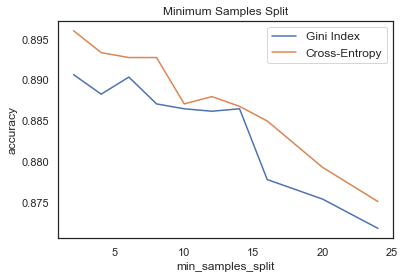

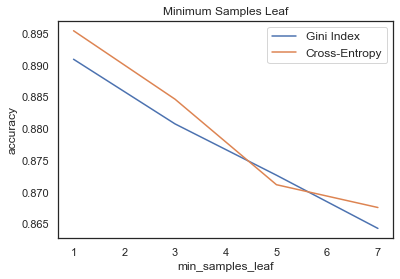

In [89]:
font = 12

# visualizing changes in min_samples_split
plt.plot('min_samples_split','acc_gini', data=results_min_split, label='Gini Index')
plt.plot('min_samples_split','acc_entropy', data=results_min_split, label='Cross-Entropy')
plt.xlabel('min_samples_split', fontsize=font)
plt.ylabel('accuracy', fontsize=font)
plt.title('Minimum Samples Split', fontsize=font)
plt.legend(fontsize=font)
plt.savefig('Figures/Decision_Trees/min_samples_split.png', bbox_inches = 'tight')
plt.show()

# visualizing changes in min_samples_leaf
plt.plot('min_samples_leaf','acc_gini', data=results_min_leaf, label='Gini Index')
plt.plot('min_samples_leaf','acc_entropy', data=results_min_leaf, label='Cross-Entropy')
plt.xlabel('min_samples_leaf', fontsize=font)
plt.ylabel('accuracy', fontsize=font)
plt.title('Minimum Samples Leaf', fontsize=font)
plt.legend(fontsize=font)
plt.savefig('Figures/Decision_Trees/min_samples_leaf.png', bbox_inches = 'tight')
plt.show()

``min_samples_split``:\
The highest accuracy can be achieved when using the Cross-Entropy as the criterion and setting the minimum number of samples required to split an internal node to 2. With a higher number of minimum samples the accuracy decreases.\
Generally, the Cross-Entropy achieves as good or even better results than when using the Gini Index as the criterion to measure the quality of a split. 

``min_samples_leaf``:\
The highest accuracy is achieved when the parameter min_samples_leaf is set to 1 and the Cross-Entropy is used as the criterion-setting. However, if min_samples_leaf is greater or equal to 6, the Gini-Index achieves better results. 

Although in this example, higher accuracies can be achieved by using the Cross-Entropy as the criterion, in both cases, the best results are received for the following parameter settings: 
``min_samples_split``= 2
``min_samples_leaf``= 1


In [90]:
max_acc_gini = round(results_min_split.acc_gini.max()*100,2)
max_acc_entropy = round(results_min_split.acc_entropy.max()*100,2)
delta = abs(round((max_acc_gini-max_acc_entropy),2))
if max_acc_gini>max_acc_entropy:
    print('The highest accuracy can be achieved with the criterion \'gini\':', +str(max_acc_gini)+ '%')
    print('With the Gini-Index the accuracy is ' +str(delta)+ '% higher than with the Cross-Entropy.')
else:
    print('The highest accuracy can be achieved with the criterion \'entropy\': '+ str(max_acc_entropy)+ '%')
    print('With the Cross-Entropy the accuracy is ' +str(delta)+ '% higher than with the Gini-Index.')

The highest accuracy can be achieved with the criterion 'entropy': 89.6%
With the Cross-Entropy the accuracy is 0.53% higher than with the Gini-Index.


### Pruning

To overcome the drawback of the previous methodology, we can create a smaller tree with
fewer splits. This might lead to lower variance and better interpretation at the cost of a little bias. By default, no pruning is performed. With the parameters provided for the Decision Tree Classifier (e.g. ``min_samples_leaf``)  overfiting can be prevented. The influence of those parameters on the Decision Tree were already explored earlier.
 
The goal of pruning is to select the subtree leading to the lowest test error rate. However, it is rather complicated to consider every possible subtree.

#### Investigate the parameter ``max_depth``

First, take a look at the parameter ``max_depth`` which controls the depth of the trees. By default ``max_depth``is set to 'None'. In that case, the nodes are expanded until all leaves are pure **or** until all leaves contain less than min_samples_split samples.\
In the following, it is investigated how simple changes in ``max_depth`` impact the tree. Ideally, a smaller tree can be created with a sufficent accuracy.

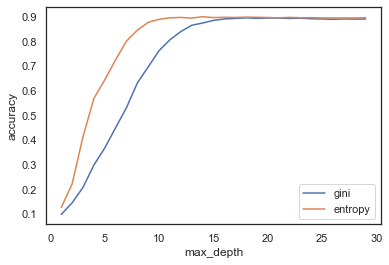

In [91]:
max_depth = []
acc_gini = []
acc_entropy = []

X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

for i in range(1,30):
    
    max_depth.append(i)
    
    clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    acc_gini.append(accuracy_score(y_test, y_pred))
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, y_pred))

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figures/Decision_Trees/max_depth.png', bbox_inches = 'tight')
plt.show()

With an increasing depth, the accuracy increases as well. However, by increasing the ``max_depth``, the computation time rises as well. For a depth greater than 15 both criterions perform similarily well.

#### Post Pruning with Cost Complexity Pruning

Another option is 'cost complexity pruning'. Here, a sequence of trees is considered instead of all the possibilities. The pruning decision is based on the value of the cost complexity parameter ``ccp_alpha``. In each iteration, the subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. The greater the cost complexity paramater ``ccp_alpha`` the higher the number of nodes that are pruned, which increases the total impurity of its leaves.\
With the parameter ``min_impurity_decrease``of the Decision Tree Classifier we can set a value so that a node will only be split if the split induces a impurity decrease of at least that value. However, here we decided to follow a script, published on Scikit-Learn.

In a first step, the Decision Tree Classifier is created and trained. Then the cost_complexity values are determined.

In [92]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

clf = tree.DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 


ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas= ccp_path.ccp_alphas
impurities = ccp_path.impurities

Then the total impurity is plotted over alpha for the training set:

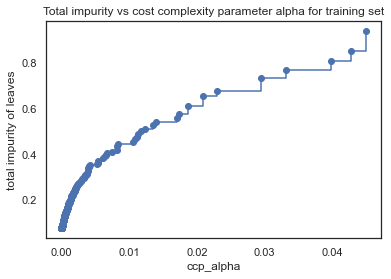

In [93]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("total impurity of leaves")
plt.title("Total impurity vs cost complexity parameter alpha for training set")
plt.savefig('Figures/Decision_Trees/total_impurity.png', bbox_inches = 'tight')
plt.show()

As explained earlier, the larger alpha, the larger the impurity. For the largest alpha, naturally, the impurity is one.

Next, the decision tree is trained using the alpha-values that were determined earlier.\
Some values in 'ccp_alphas' are very small, negative values. However, per definition alpha is supposed to be non-negative and can only take values that are greater or equal to zero. Therefore, in the following very small but negative alphas will be set to 0 to avoid potential errors.

In [94]:
clfs = []
for ccp_alpha in ccp_alphas:
    if round(ccp_alpha,10)==0: 
        ccp_alpha = 0
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: %d with ccp_alpha: %3.4f".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: %d with ccp_alpha: %3.4f


Now, show the number of nodes and the tree depth over alpha:

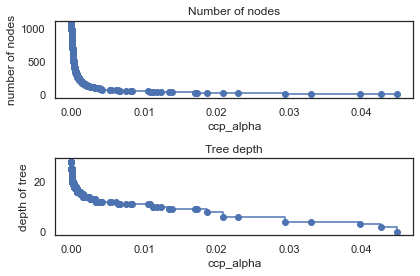

In [95]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("ccp_alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("ccp_alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Tree depth")
plt.savefig('Figures/Decision_Trees/Nodes_and_Tree_depth.png', bbox_inches = 'tight')
fig.tight_layout()

Both, the number of nodes and the depth decreases with an increasing alpha.

Comparing the training and test accuracies depending on the current alpha:

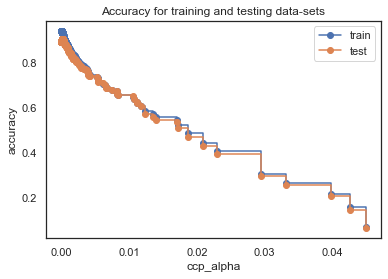

In [96]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy for training and testing data-sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.savefig('Figures/Decision_Trees/Accuracy_and_ccp_alpha.png', bbox_inches = 'tight')
plt.show()

When ``ccp_alpha`` is set to zero and all the other parameters of the Decision Tree Classifier are kept at their default values, the tree tends to overfit. With a higher alpha, more nodes of the tree are pruned and a tree is generated, that generalizes better. However, it seems that for this example setting ``ccp_alpha`` to zero results in the highest overall accuracy.

As mentioned above, decision tree is a simple classifier. It suffer from high variance with pruning, therefore we now considering the bagging, which sampling the original dataset with replacement as training data  for each of the n trees.Furthermore, the feature cadidates for splitting are also bootstraped to reduce the correlation between each tree, that is the Random Forest.

## Random Forest

## Create a Random Forest

At first, we take look at an example calssifier. This example classifier is almost a standard random forest classifier except that the parameter min_samples_leaf is set to 5.

**Note**: The exact value of overall accuracy, accuracy in confusion matrix and even the ranking of the feature importance might slightly differ from the ones written in the comments because of the randomness in the algorithm.

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

### Create a First Version of a Random Forest

In a first step, the data-set 'learn_df' is split into a test and training data-set. After fitting the random forest classifier to the training data-set and then use the test data-set to test the model. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], train_size=0.67, random_state=1)

rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)

a = accuracy_score(y_test, y_pred)
print('Overall accuracy of all category: ' +str(round(a,4)))

Overall accuracy of all category: 0.8025


**Note** : This overall acuracy is not weighted by sample size , so even for a category with a small size where the performance is really bad, we still have an acceptable overall accuracy.

#### Evaluation of this First Version of a Random Forest

In order to evaluate the performance of this first random forste model the importance of the individual features are compared.

In [99]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

depth              0.300922
height             0.249894
name               0.219182
width              0.082390
price              0.057591
designer           0.054339
other_colors       0.018763
item_id            0.016920
sellable_online    0.000000
dtype: float64

Text(0.5, 1.0, 'Feature importance')

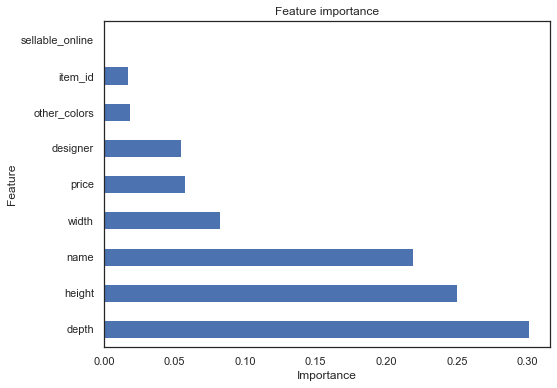

In [100]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

The bar-graph shows the importance of the individual features in increasing order. The most important features are 'depth' and 'height' with approx. 30% and 26%, respectively. As expected, again, sellable_online does not have any importance.   

Now lets check the confusion matrix to examine the acuracy for the individual categories:

In [101]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

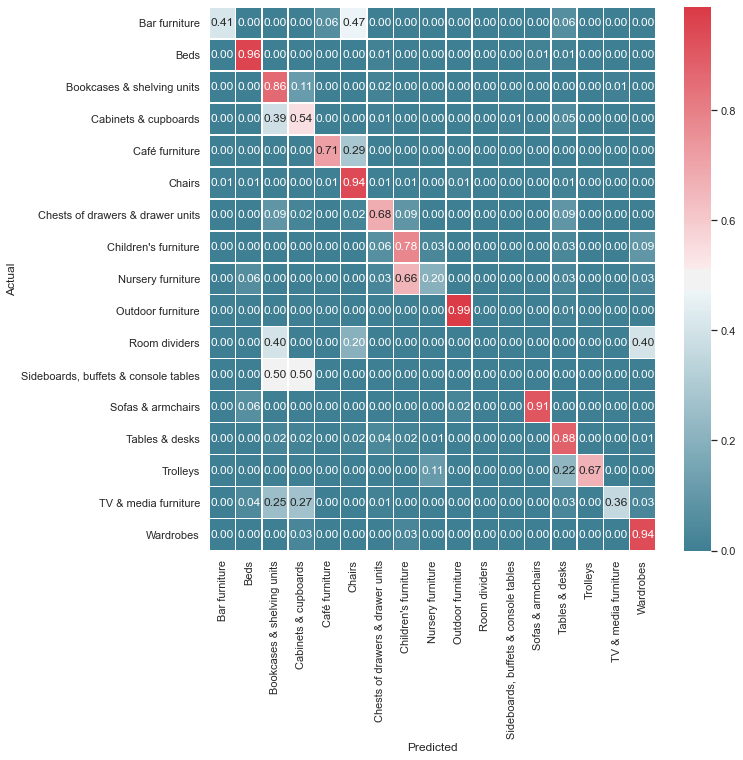

In [102]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_1.png', bbox_inches = 'tight')

An analysis of this confusion matrix will be given later; toghether with the next plot.

### First Improvements of the Random Forest
First improvement by further selection of the features by only keeping the important features.
From feature importance report we get that size data  play the  great role in prediction, as we asuumed before in feature analysis. In addition name of the items is also important. Lets see what happens if we just keep those 5 top features with importance  larger than around 5%. We remove the feature **sellable online**, **item_id** and **other_colors**.

In [103]:
# we need item_id and category in dataframe for other use, not for training
learn1 = ['item_id','height','depth','width','name','designer','category','category_num']
learn_df1 = learn_df[learn1]

In [104]:
# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df1.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df1['category_num'],train_size=0.67, random_state=1)
# create random forest
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.8172131147540984


The overall acuracy increased from about 80% to 82%

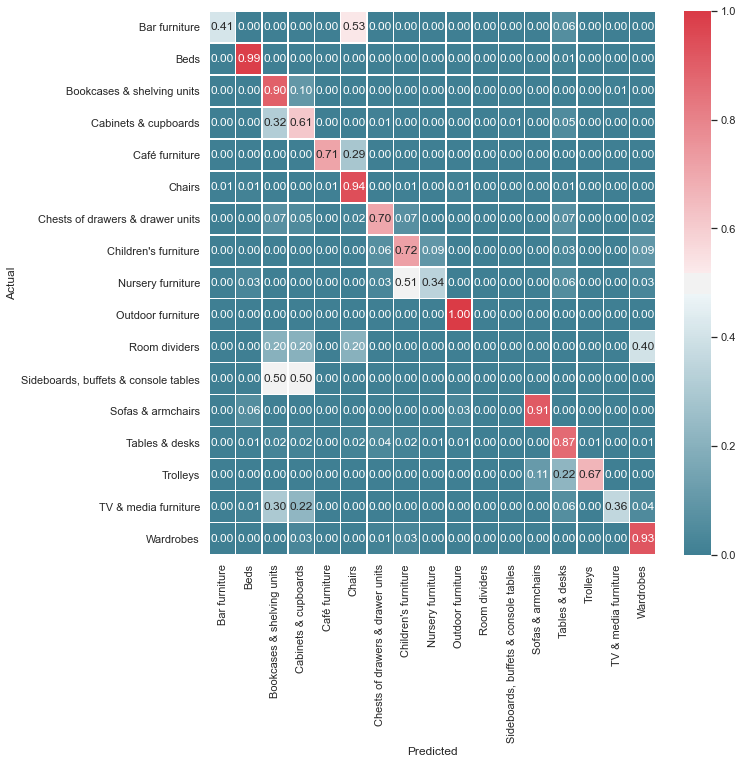

In [105]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_2.png', bbox_inches = 'tight')

Compare the both confusion matrix we get that through feature selection,  we increase the overall accuracy at about1%  in the way that the accuracy for category Nursury furniture have been significantly increased by 10% respectly. And it is clear that the category with the worst performance: Room diveider with 0%, Sideboards & console tables with 0%, then Bar furniture 42%. Those are exactly the category with smallest sample size in whole data-set. As we mentioned above we can replicate  those samples to make it to a  ralative balanced multi-class classification task. The category TV & media furniture perform also not good, 30% TV& medianfurnitures have been predicted as Book cases & shelving unit. Considering the feature importance and boxplot of height and depth, we find that those two category have really simillar distribution shown in boxplot of those top 2 features.No wonder then.To our supprise, category Trolleys ,of which samples size is just 28, has the outstanding performance. We did not find the obvious clue from  its size  and price. We take look at the data set and find  the option for its name and designer is restricted and this might be the reason.  

### Final Version of the Random Forest
Improve the results by replicating the samples for the categories with a small sample size. This is the case for the following categories: 'Room dividers' and 'Sideboards, buffets & console tables'.
The categories with small sample sizes in the data-set are replicated in order to make this multi class classification task be relativly balanced. As the results will prove, the accuracy of the model can be increased significantly by doing so.

In [106]:
#recall the sample size of each category
size_df = learn_df1.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [107]:
# careful here the order of the labels somehow changed compared to the list 'label' above. The order of TV & median furniture
# tables& dsks and trollyes somehow echanged as can be seen below . Thus, we cannot use the list label to display the correct order of 
# column names in this section.
label1 =size_df['category'].tolist()
if label != label1:
    print('label does not equal label1. In the following, therefore label1 will be used.')

label does not equal label1. In the following, therefore label1 will be used.


In [108]:
label_size = size_df['size'].tolist()
label_size

[47, 208, 548, 292, 26, 481, 125, 124, 97, 216, 13, 23, 428, 190, 612, 28, 236]

In [109]:
learn_df2 = learn_df1.copy() 

In [110]:
# using label1 instead of label!
#print(learn_df2.shape[0])
for k in range(17):
    temp_df = learn_df1[learn_df1['category'].str.contains(label1[k])] 
    #print('original size' + str(temp_df.shape[0]))
    #print('label_size' +str(label_size[k]))
    tt = round(max(label_size)/label_size[k]) -1
    #print('to replicate' + str(tt))
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        #print('df_repl size' +str(temp_df1.shape[0]))
        learn_df2 = pd.concat([learn_df2, temp_df1] , ignore_index=True)
        #print(learn_df2.shape[0])

In [111]:
# old data-set imbalanced
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [112]:
#new relative balanced data set with duplicated samples
size_df2 = learn_df2.groupby('category').size().reset_index(name='size')
size_df2

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


Now that the data-set has been modified, the samples are relatively balanced - even though there are many duplicated samples for the categories that only had very few samples before.
Thus in a next step, the final version of the random forest can be created. 

In [113]:
X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df2['category_num'],train_size=0.67, random_state=1)
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.889754343918514


Despite the replicated samples, we were able to increase the overall accuracy from about 82% to 89%.

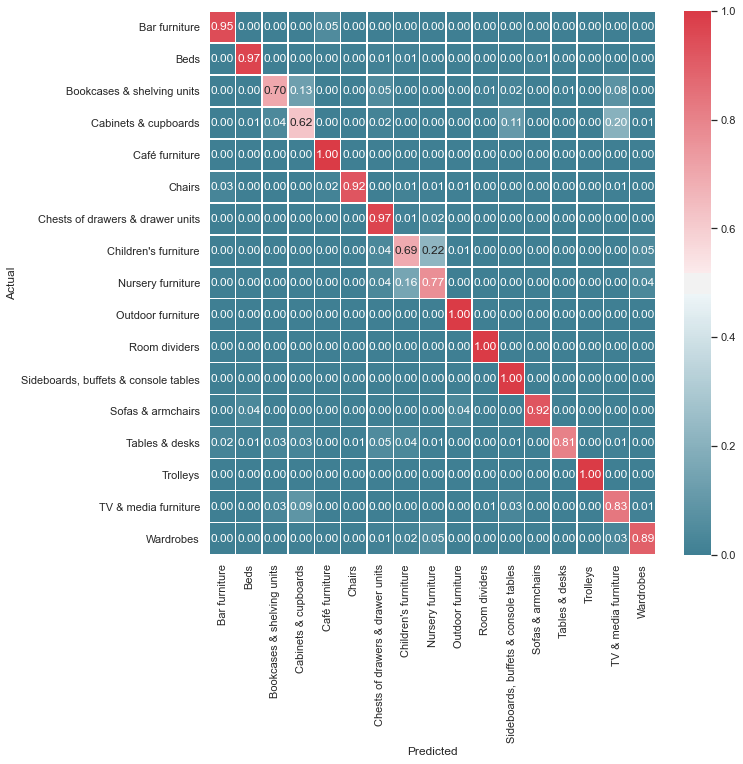

In [114]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_3.png', bbox_inches = 'tight')

Now we have an almost perfect diagonal matrix we desired. Through repeating samples to make size of each category  balanced,  the acuracy of prediction for Bar funiture has been increased from 42% to 95% ,  for Room dividers from 0% to 100%,  for Sideboards, buffets & console rable from 0% to 100% etc, those are the catogry whose samples are mostly replicated. It is still hard for the algorithm to distinguish nursery furniture from children furniture.The reason is clear that consering two the immportant features: height and depth, the distribution are almost the same in the box plot.  

In [115]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

name        0.300966
depth       0.285504
height      0.243049
width       0.097309
designer    0.073172
dtype: float64

And now with replicated samles in data set , the feature name(former) becomes the most important feature, followed by height (former top1) and depth(former top2).

### Further Investigations of the Random Forest Model

 Now we try out different parameter settings to see if we can get better predictions. After trail and error we keep the following parameter sets to show the impact of those parameters. Best minimum samples in leaf  is  1 (we set 5 before), if increase the size the overall predictions accuracy goes down. Normally the acurracy increase with the size of forest until  reaching certain threshold and the accuracy become stable. In total those parameters just influence the overall acuracy less than 0.01, and the best overall accuracy witih random forest is about 90.27% for minimum_samples_leaf =1, n_tree = 400. Here we won't check the single confusion matrix, since the data-set is now balanced w.r.t sample size of each category. 

In [116]:
def RandomForest(n_tree, min_leaf, learn_df):
    
    X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['category_num','category','item_id']), \
                                                        learn_df2['category_num'], random_state=1)
    start_time = time.time()
    rf =  RandomForestClassifier(n_estimators = n_tree,criterion = 'gini', min_samples_leaf = min_leaf,random_state =1,\
                                 oob_score=True,warm_start=True)
    rf.fit(X_train,y_train)
    y_pred =  rf.predict(X_test)
    end_time = time.time()
    #print('time consumption: '+ str(end_time - start_time))
    # overall acuracy
    a = accuracy_score(y_test, y_pred)
    oob = rf.oob_score_
    return a, oob
# uncomment all below to check the confusion matrix for each loop
#     # confusion matrix   
#     m =  confusion_matrix(y_test, y_pred)
#     #calculate total number of samples of each category in X_test
#     m_sum = m.sum(axis = 1)
#     m1 = np.zeros((17,17))
#     for k in range(17):
#          m1[k,:] = m[k,:]/m_sum[k]
#     m_df = pd.DataFrame(m1,index = label, columns=label)
#     #plot confusion matrix
#     fig, ax = plt.subplots(figsize=(10,10))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.heatmap(m_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Actual')
#     ax.figure.savefig('Figures/RF_CM_Param_'+str(i)+ '_' + str(l) +'_'+str(round(a,3))+'_.jpg',bbox_inches = 'tight')

In [117]:
# number of the  decision tree in forest
n_tree = [20,40,60,100,200,400,600,1000,1200,1400]
# those two criterion almost make no difference to overall acuracy,  too complicated to examine their impact on each category
# so just use the default gini index
#crit = ['gini','entropy']
# minimum number of samples in the leaf (end node)
min_leaf = [1,3,5,7,9,13]

In [118]:
y1 = []
for l in range(len(min_leaf)):
    a, oob = RandomForest(100, min_leaf[l],learn_df2)
    y1.append((a,oob)) 
    #print("===========================================")
    #print('Overall acuracy: ' +str(a))
    #print('Out-of-bag score: ' +str(oob))

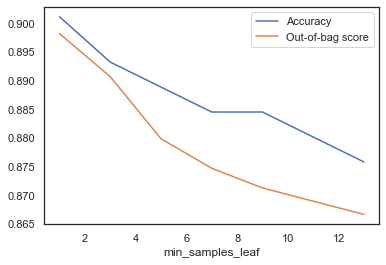

In [119]:
plt.plot(min_leaf,y1)
plt.legend( ['Accuracy','Out-of-bag score'])
plt.xlabel("min_samples_leaf")
plt.savefig('Figures/Random_Forest/oob1.pdf')

From the graph above, we see the larger is the min_samples_leaf, the larger is the gap between the accuracu and out of bag scorem which indicates that the worse the model fitted to the data set.

In [120]:
y2 = []
for i in range(len(n_tree)):
    a, oob = RandomForest(n_tree[i], 1,learn_df2)
    y2.append((a,oob)) 
    #print("===========================================")
    #print('Overall acuracy: ' +str(a))
    #print('Out-of-bag score: ' +str(oob))

C:\Users\Marimo\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Marimo\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


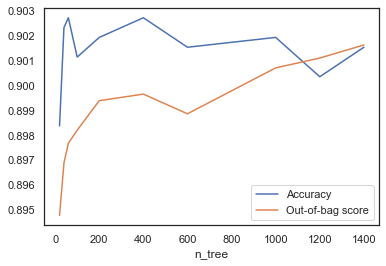

In [121]:
plt.plot(n_tree,y2)
plt.legend( ['Accuracy','Out-of-bag score'])
plt.xlabel("n_tree")
plt.savefig('Figures/Random_Forest/oob2.pdf')

As we can see from the plot above, the larger the forest is, the smaller is the gap between OOB score and the accuracy, which means the better the classifier fitted to the data.

## Boosting

In [123]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import time

### Test and Training Data-sets

In a first step, the dataset ``'learn_df'`` is split into a test- and training-dataset. The predictors for this first model will be the follwing features: ``'item_id'``, ``'name'``, ``'price'``, ``'sellable_online'``, ``'other_colors'``, ``'designer'``, ``'depth'``, ``'height'``, ``'width'``. Then the model can be trained and first predictions can be made.

In [124]:
#get unique labels of data
labels = IKEA_df['category'].unique()

# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], train_size=0.67, random_state=1)

### First Version of the Boosting

We are exploring the method of Boosting in order to classify the IKEA Furniture Data-Set. For performance tests we will use the default parameters such as ``loss`` = deviance, ``learning_rate`` = 0.1, ``n_estimators`` = 100 and ``max_depth`` = 3. The parameter ``criterion`` is by default the friedman_mse. Random splitting was not investigated in this context. As last step we will further investigate the influence of some parameters on our model.

In [125]:
booster = GradientBoostingClassifier()

In [126]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

##### Evaluation of this First Version

In [127]:
predictors = learn_df.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

feature_importances = boost_est.feature_importances_
features = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
features

,Importance
depth,0.394105
name,0.245991
height,0.244053
width,0.040172
price,0.028560
designer,0.026311
item_id,0.015700
other_colors,0.004933
sellable_online,0.000175


As the table shows, the most important features are  ``'depth'`` (approx. 40%) ,``'name'`` (approx. 25%), and ``heigth`` (approx. 25%). Other features such as ``'price'``, ``'item_id'`` or ``'designer'`` account for less than 3%. As was suspected earlier when analyzing the raw-data, the feature ``'sellable_online'`` does not have any importance as almost all products are sellable online. It is similar for the feature ``'other_colors'`` as most items are available in different colors. On the contrary, ``'item_id'`` is unique for the vast majority of items, therefore the feature 'item_id' is not a good indicator for the item category as well, resulting in a low importance of the feature.

In a next step the confusion matrix is created and the training and test accuracy are computed.

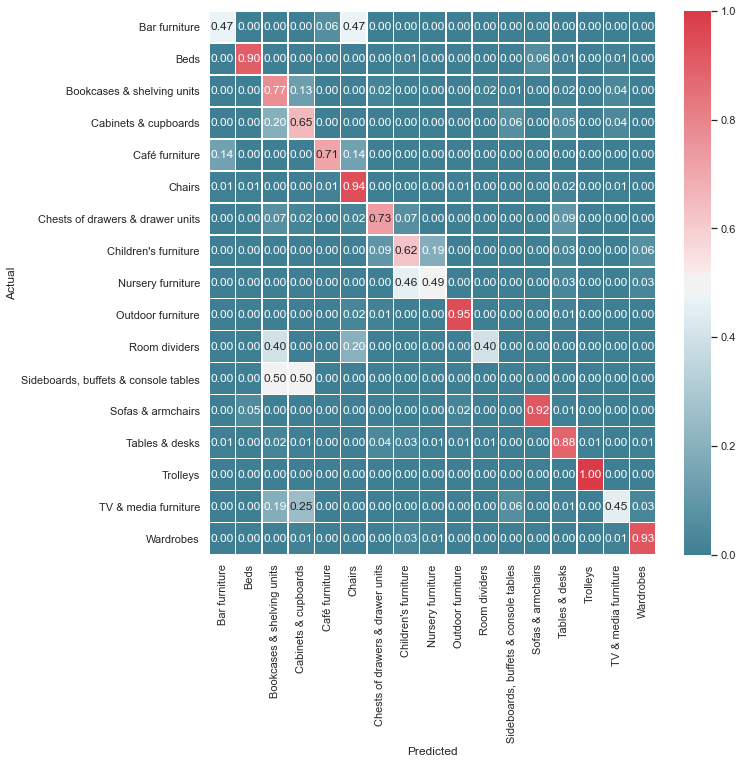

In [128]:
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Boost/boost_CM1.png', bbox_inches = 'tight')

If we look at the confusion matrix, we see that we have problems to classify some classes such as ``'Bar furniture'`` or ``'Room dividers'``. Additionally we were not able to classify ``'Sideboards, buffets & console tables'`` correctly at all. Due to these classification errors we need do improve our model. 

In [134]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)

# determine test accuracy
accuracy_test_1 = accuracy_score(y_test, y_pred)
print("Model test accuracy:", accuracy_test_1)

Model test accuracy: 0.8131147540983606


### First Improvements of Boosting

As a first attempt to improve the model, all features with an importance of less than 3% are excluded from the set of predictors. This is the case for the following features: ``'Price'``, ``'Item_id'``, ``'Designer'``, ``'Other_colors'`` and ``'Sellable_online'``. For that, adjust the dataframe which is used to create the training and test dataset and then fit the data for boosting ('learn_df_improvement').

In [135]:
learn = ['height','depth','width','name','category','category_num']
learn_df_improvement = learn_df[learn]

In [136]:
# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df_improvement.drop(columns = ['category','category_num']), \
                                                    learn_df_improvement['category_num'], train_size=0.67, random_state=1)

In [137]:
booster = GradientBoostingClassifier()

In [138]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

##### Evaluation of this Second Version

In [139]:
predictors = learn_df_improvement.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

feature_importances = boost_est.feature_importances_
features = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
features

,Importance
depth,0.410335
name,0.276998
height,0.258949
width,0.053718


As the table shows, all of the features account for more than 5% of the prediction.

In a next step the confusion matrix is created and the training and test accuracy are computed.

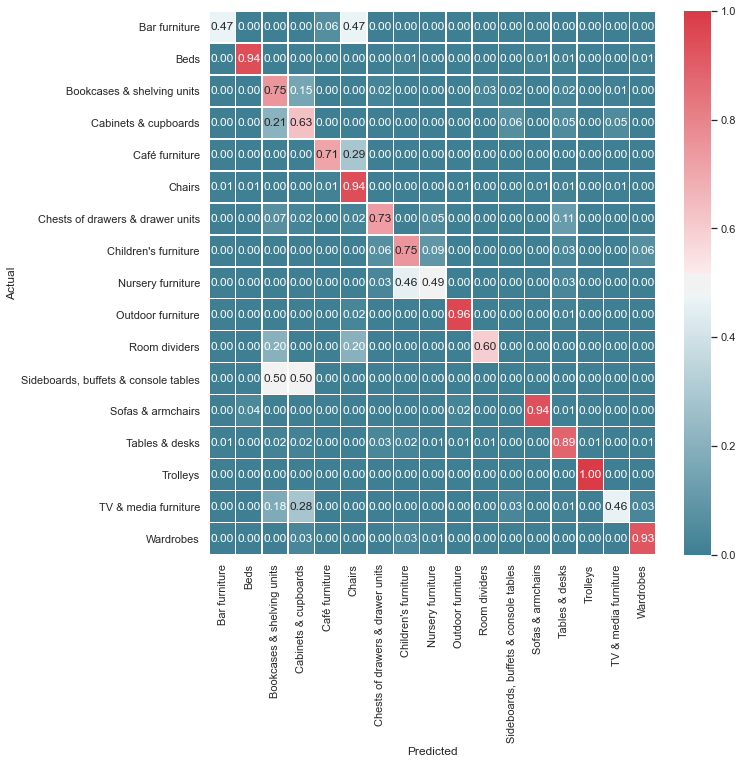

In [140]:
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Boost/boost_CM2.png', bbox_inches = 'tight')

If we look at the confusion matrix, we see that for some classes we have lost a little bit of predictive power. However, we have been able to improve the overall predictability. But we were still unable to classify ``'Sideboards, buffets & console tables'`` correctly at all. Due to these classification errors we need to further improve our model. 

In [141]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)
accuracy_train_2 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_2-accuracy_train_1)/accuracy_train_2)*100,2)
print("Training accuracy:", round(accuracy_train_2,4))
if improvement_train >0.0:
    print("The training accuracy improved by " +str(improvement_train)+ "%.\n")
elif improvement_train <0.0:
    print("The training accuracy deteriorated by " +str(improvement_train)+ "%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")

# determine test accuracy
accuracy_test_2 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_2,4))
improvement_test = round(((accuracy_test_2-accuracy_test_1)/accuracy_test_2)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ "%.\n")
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ "%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.9163
The training accuracy improved by 6.13%.

Test accuracy: 0.8131
No improvement of the test accuracy.



### Final Version of Boosting

In the data analysis we found, that the sample size varies depending on the category. We noticed that especially for those categories, that have fewer samples, the decision tree performs poorly. In an effort to balance the sample size of categories with very few samples, some samples were replicated. Recall the sample size of the individual categories.


In [142]:
#recall the sample size of each category
size_df = learn_df_improvement.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


Remeber the confusion matrix after the first improvments: The prediction accuracy of the categories ``'Sideboards, buffets & console tables'``, ``'Room dividers'`` was significantly lower than for the other categories. Both categories have a very low number of samples compared to other categories such as ``'Beds'`` where the prediction accuracy was 90%

In [143]:
# order of column names in this section.
label1 =size_df['category'].tolist()

if label!=label1:
    print('Label does not equal label1. In the following, therefore label1 will be used.')

Label does not equal label1. In the following, therefore label1 will be used.


In [144]:
learn_df_final = learn_df_improvement.copy(deep=True)

In [145]:
label_size = size_df['size'].tolist()
for k in range(len(label1)):
    temp_df = learn_df_improvement[learn_df_improvement['category'].str.contains(label1[k])] 
    tt = round(max(label_size)/label_size[k]) -1
    if tt > 0:
        temp_df_improvement = pd.concat([temp_df]*tt, ignore_index=True)
        learn_df_final = pd.concat([learn_df_final, temp_df_improvement] , ignore_index=True)

In [146]:
#new relative balanced data set with duplicated samples
size_df_final = learn_df_final.groupby('category').size().reset_index(name='size')
size_df_final

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


By replicating samples for some categories, the number of samples of the dataset now is relatively balanced. However, note that by replicating samples now the categories which were lacking samples before now contain many duplicate samples.

In [147]:
# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df_final.drop(columns = ['category','category_num']), \
                                                    learn_df_final['category_num'], train_size=0.67, random_state=1)

In [148]:
booster = GradientBoostingClassifier()

In [149]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

##### Evaluation of this Final Version

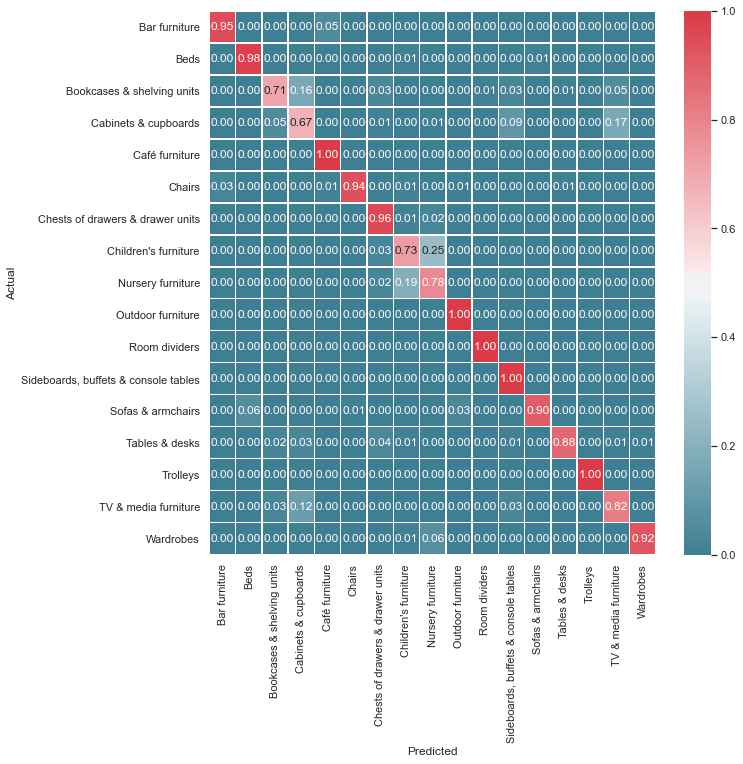

In [150]:
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Boost/boost_CM3.png', bbox_inches = 'tight')

If we look at the confusion matrix, we see that we could improve the accuracy dramatically. We could also classify the class for ``'Sideboards, buffets and console tables'`` at a rate of 100%. Maybe we can improve the class by ajusting some parameters for the boosting. 

In [151]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)
accuracy_train_3 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_3-accuracy_train_2)/accuracy_train_3)*100,2)
print("Training accuracy:", round(accuracy_train_2,4))
if improvement_train >0.0:
    print("The training accuracy improved by " +str(improvement_train)+ "%.\n")
elif improvement_train <0.0:
    print("The training accuracy deteriorated by " +str(improvement_train)+ "%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")

# determine test accuracy
accuracy_test_3 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_3,4))
improvement_test = round(((accuracy_test_3-accuracy_test_2)/accuracy_test_3)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ "%.\n")
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ "%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.9163
The training accuracy improved by 0.41%.

Test accuracy: 0.9005
The test accuracy improved by 9.71%.



### Further Investigations of Boosting Model

Now we examine how the boosting performs for different parameter settings. Using 'trial and error' we iteratively investigate the impact of the following parameters: ``'max_depth'``, ``'estimators'``, ``'learning_rate'``, ``'min_samples_split'`` and ``'min_samples_leaf'``.

At first we will start to with different values for ``'max_depth'``, ``'estimators'`` and ``'learning_rate'``.

In [152]:
estimator = [100, 125, 150]
learning_rate = [0.075, 0.1, 0.125]
depth = [3, 5, 7] 

In [155]:
#create train method
def train(X_train, X_test, y_train, y_test, boost):    

    booster = boost
    
    boost_est = booster.fit(X_train, y_train)
       
    # Make predictions
    y_pred = boost_est.predict(X_test)
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred

In [156]:
result = []

#run through all parameters to find best solution
for lr in learning_rate:
    for est in estimator:
        for d in depth:
            start_time = time.time()
            booster = GradientBoostingClassifier(learning_rate=lr, n_estimators=est, max_depth=d, random_state=0)
            accuracy, y_pred = train(X_train, X_test, y_train, y_test, booster) 
            end_time = time.time() - start_time

            result.append(
                {
                    'learning_rate': lr,
                    'n_estimators': est ,
                    'max_depth': d,
                    'time_needed': end_time,
                    'test_accuracy': accuracy,
                    }
                )
            print('======Process for Parameter: estimator %d, lr %4.3f, depth %i, ======' % (est, lr, d,))
            print('time consumption: '+ str(end_time))
            print('Overall accuracy: ' +str(accuracy))

======Process for Parameter: estimator 100, lr 0.075, depth 3, ======
time consumption: 9.342490673065186
Overall accuracy: 0.896345116836429
======Process for Parameter: estimator 100, lr 0.075, depth 5, ======
time consumption: 11.53787875175476
Overall accuracy: 0.9014379868184542
======Process for Parameter: estimator 100, lr 0.075, depth 7, ======
time consumption: 14.661590099334717
Overall accuracy: 0.8981426003594967
======Process for Parameter: estimator 125, lr 0.075, depth 3, ======
time consumption: 10.264086723327637
Overall accuracy: 0.8984421809466746
======Process for Parameter: estimator 125, lr 0.075, depth 5, ======
time consumption: 13.805996656417847
Overall accuracy: 0.9014379868184542
======Process for Parameter: estimator 125, lr 0.075, depth 7, ======
time consumption: 16.666051149368286
Overall accuracy: 0.8996405032953865
======Process for Parameter: estimator 150, lr 0.075, depth 3, ======
time consumption: 12.618518352508545
Overall accuracy: 0.901737567405

In [157]:
#result to pandas DataFrame
res1 = pd.DataFrame(result)

#search for the accuracy better than 0.8 in contrast to time consumption
best_list = []
best1 = 1000
ident = 0
for i in range(len(res1)):
    tmp = res1['time_needed'][i]/res1['test_accuracy'][i]
    if best1 > tmp:
        best1 = tmp
        ident = i
        best_list.append([i])

est =res1['n_estimators'][ident]
lr = res1['learning_rate'][ident]
d = res1['max_depth'][ident]
test_accuracy1 = res1['test_accuracy'][ident]
time_needed1 = res1['time_needed'][ident]
    
print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (est, lr, d, test_accuracy1, time_needed1))

n_estimators: 100
learning_rate: 0.125
max_depth: 3

test_accuracy: 0.9011
time consumption: 7.8141


Comparing the time consumption in the different parameter configurations, we can see that a higher number of estimators and an increased maximum depth will partly lead to double the time consumption. Therefore we will consider the duration of the calculation in order to find a trade of between consumtion and accuracy. Additionally we will seek for the overall best accuracy.

In [158]:
test_accuracy =  res1['test_accuracy'].max()
best_lr = res1.loc[res1['test_accuracy'].idxmax(), 'learning_rate']
best_est = res1.loc[res1['test_accuracy'].idxmax(), 'n_estimators']
best_depth = res1.loc[res1['test_accuracy'].idxmax(), 'max_depth']
time_needed = res1.loc[res1['test_accuracy'].idxmax(), 'time_needed']

print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (best_est, best_lr, best_depth, test_accuracy, time_needed))                                

n_estimators: 150
learning_rate: 0.100
max_depth: 3

test_accuracy: 0.9050
time consumption: 13.4481


Considering the two found solutions we can say that an improvement of 0.4% can be achieved if we ignore the time consumption. Comparing the different computation times of the models it can be said that ``n_estimator`` and ``max_depth`` are responsible for a large part of the time needed. For further investigations we take a closer look at the parameters for ``min_sample_split`` and ``min_sample_leaf``. The before tested optimal parameters considering the time to accuracy ratio were used in the next steps. The parameters are ``learning_rate`` = 0.125, ``max_depth`` = 3 and ``n_estimators`` = 100.

Now we will try different values for ``min_samples_split`` and ``min_samples_leaf``.

The parameter ``min_samples_split`` defines the minimum number of samples needed to split the tree. This value was previously set by default on 2. Now we wil investigate, how this value influences the overall accuracy of the decision tree.\
The parameter ``min_samples_leaf`` defines the minimal number of samples to be at a leaf node. Thus, split points will only be considered if at least min_samples_leaf training samples are left in each of the branches. This value was previosly set by default on 1.

In [159]:
estimator = 100
learning_rate = 0.125
depth = 3 
leaf = [1,3,5]
split = [2,4,6,8,12,14,16]

result2 = []

for l in leaf:
    for s in split:
        start_time = time.time()
        booster = GradientBoostingClassifier(min_samples_split=s, min_samples_leaf=l,learning_rate=learning_rate, n_estimators=estimator, max_depth=depth, random_state=0)
        accuracy, y_pred = train(X_train, X_test, y_train, y_test, booster) 
        end_time = time.time() - start_time
        #save results
        result2.append(
            {
                'learning_rate': lr,
                'n_estimators': est ,
                'max_depth': d,
                'min_samples_leaf': l,
                'min_samples_split': s,
                'time_needed': end_time,
                'test_accuracy': accuracy,
                }
            )
        print('Process for Param estimator %d, lr %4.3f, depth %i, min_leaf %i, min_split %i' % (est, lr, d, l, s))
        print('time consumption: '+ str(end_time))
        print('Overall accuracy: ' +str(accuracy))

Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 2
time consumption: 13.00151777267456
Overall accuracy: 0.9011384062312762
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 4
time consumption: 12.926066160202026
Overall accuracy: 0.9017375674056322
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 6
time consumption: 12.56049108505249
Overall accuracy: 0.9035350509286998
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 8
time consumption: 12.903958797454834
Overall accuracy: 0.9020371479928101
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 12
time consumption: 13.930383205413818
Overall accuracy: 0.9008388256440982
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 14
time consumption: 13.71304178237915
Overall accuracy: 0.9011384062312762
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 16
time consumption: 12.227

In [160]:
#result to pandas DataFrame
res2 = pd.DataFrame(result2)

#search for the accuracy better than 0.8 in contrast to time consumption
best_list2 = []
best2 = 1000
ident = 0
for i in range(len(res2)):
    tmp = res2['time_needed'][i]/res2['test_accuracy'][i]
    if best2 > tmp:
        best2 = tmp
        ident = i
        best_list2.append([i])

est =res2['n_estimators'][ident]
lr = res2['learning_rate'][ident]
d = res2['max_depth'][ident]
test_accuracy2 = res2['test_accuracy'][ident]
time_needed2 = res2['time_needed'][ident]
l = res2['min_samples_leaf'][ident]
s = res2['min_samples_split'][ident]
    
print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\nmin_samples_leaf: %i\nmin_samples_split: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f\n" % (est, lr, d, l, s, test_accuracy2, time_needed2))

if best1 -best2 >= 0:
    print("In comparison to the best set of the first time to accuracy parameters,\nthe second set has a better ratio (%4.4f) in contrast to an accuracy of %4.4f\nand %4.3f seconds (%4.4f)."%(best2, test_accuracy1, time_needed1, best1))
else:
    print("In comparison to the best set of the first time to accuracy parameters,\nthe second set has a worse ratio (%4.4f) in contrast to an accuracy of %4.4f\nand %4.3f seconds (%4.4f)."%(best2, test_accuracy1, time_needed1, best1))

n_estimators: 100
learning_rate: 0.125
max_depth: 3
min_samples_leaf: 5
min_samples_split: 16

test_accuracy: 0.9011
time consumption: 8.2131

In comparison to the best set of the first time to accuracy parameters,
the second set has a worse ratio (9.1141) in contrast to an accuracy of 0.9011
and 7.814 seconds (8.6714).


In [161]:
test_accuracy2 =  res2['test_accuracy'].max()
best_lr2 = res2.loc[res2['test_accuracy'].idxmax(), 'learning_rate']
best_est2 = res2.loc[res2['test_accuracy'].idxmax(), 'n_estimators']
best_depth2 = res2.loc[res2['test_accuracy'].idxmax(), 'max_depth']
best_leaf2 = res2.loc[res2['test_accuracy'].idxmax(), 'min_samples_leaf']
best_split2 = res2.loc[res2['test_accuracy'].idxmax(), 'min_samples_split']
time_needed2 = res2.loc[res2['test_accuracy'].idxmax(), 'time_needed']

print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\nmin_samples_leaf: %i\nmin_samples_split: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (best_est2, best_lr2, best_depth2, best_leaf2, best_split2, test_accuracy2, time_needed2))                                


n_estimators: 100
learning_rate: 0.125
max_depth: 3
min_samples_leaf: 1
min_samples_split: 6

test_accuracy: 0.9035
time consumption: 12.5605


We can also see, that a variation of ``min_samples_leaf`` and ``min_samples_split`` can improve the model and does not strongly influence the computing time.

## Conclusion and Remarks

#### Decision Tree
Overall the Decision Tree Classifier could achieve a test accuracy of almost 90\%. By removing the features with an importance of less than 2\%. This reduced the number of predictors from 9 to 6. In an effort to balance the data-set, data-samples wre replicated for some categories. These tweaks lead to an improvement in the overall accuracy could by a little over 10\%.

Further, reducing the size of the tree by adjusting the parameter ``max_depth`` did not prove to increase the test accuracy of the decision tree. In addition, it was found that with the criterion set to the Cross-Entropy slightly higher accuracies can be achieved than when using the Gini Index. However, this improvement makes up for less than 1% in the optimal setting. Further, it was found that the accuracy of the decision tree could not be improved with Cost Complexity Pruning.

The best results were found for the following parameter setting:\
``min_samples_split`` = 2,\
``min_samples_leaf`` = 1,\
``criterion`` = 'entropy'.


#### Random Forest
Random forest gives a slight improvement of accuracy at about 1% compared with decision tree. Through ignoreing the feature that not contributes to **catogory** and making the training set balanced for each catogory the model has been further improved. Deatures that playing the cucial role in classification are as assumed in feature analysis: **depth** and **height**。 In addition, through replicatiing samples to make it balanced, **name**  becomes the top1 important feature.
The best model has the accuracy of 90.27% with the following parameter setting:\
``min_samples_leaf`` = 1,\
``n_estimator`` = 400,\
``criterion`` = 'entropy'.

#### Boosting
The GradientBoostClassifier could achieve a test accuracy of '' after improving the model. By removing the features with an importance of less than 3% the number of predictors could be reduced to four and the test accuracy increased by 0.6%. Due to the different distribution of categories in the data-samples we replicated some data to get an almost even distribution which lead to an increase of 9.8% for the test accuracy. 

By adjusting the parameters for ``learning_rate``, ``estimators`` and ``max_depth`` we looked for a different set of parameters which could improve the accuracy. Unfortunatly, the parameters for ``max_depth`` and ``estimators`` would increase the runtime of the model. Therefore we compared the time to accuracy ratio to determine the best trade-off between time consumption and accuracy. We found that the parameters ``learning_rate ``, ``'estimators`` and ``'max_depth`` had the best trade-off. Further improvements were done with the best found parameters.

In the last step the parameters for ``min_samples_split`` and ``min_samples_leaf`` were checked in order to further improve the model. Adjustments at these parameters would not have a big impact on the runtime. Therefore the time to accuracy ratio was ignored. This last improvement lead to the best result of a test accuracy of:

The parameters for the best result were:

**``test accuracy = 0.9050``**  <br>
**``time consumption: 31.7338``**  <br>

``learning_rate`` = 0.125  <br>
``n_estimators`` = 100  <br>
``max_depth`` = 3  <br>
``min_samples_leaf`` = 1  <br>
``min_samples_split`` = 6  <br>

It has to be mentioned that an accuracy of 0.9035 could be achieved with a different set of parameters within 20.7088 seconds.

<br>

If we consider the time consumtion, we achieved the overall best result with the parameters<br>
<br>
**``test accuracy = 0.9017``**  <br>
**``time consumption: 20.7088``**  <br>

``learning_rate`` = 0.125  <br>
``n_estimators`` = 100  <br>
``max_depth`` = 3  <br>
``min_samples_leaf`` = 3  <br>
``min_samples_split`` = 8  <br>

